In [39]:
# グラフ描画系
import json
import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc
from matplotlib_venn import venn2, venn2_circles
from matplotlib import animation as ani
from IPython.display import Image

import os
plt.rcParams["patch.force_edgecolor"] = True
#rc('text', usetex=True)
from IPython.display import display # Allows the use of display() for DataFrames
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

%matplotlib inline
%config InlineBackend.figure_format='retina'

import logging
import time
from typing import List, Optional, Union, Tuple, Dict
# from encoders import frequency_encoding
from contextlib import contextmanager
import sys
sys.path.append('../py/')
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', 1000)

from abc import ABCMeta, abstractmethod


In [9]:
import gc
from pathlib import Path
import numpy as np
import pandas as pd
import datetime
from time import time
from tqdm import tqdm_notebook as tqdm
import lightgbm as lgb
from collections import Counter
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, cohen_kappa_score
import time
#  pandas setting
pd.set_option("display.max_colwidth", 100)
# pd.set_option("display.max_rows", None)
# pd.set_option("display.max_columns", None)
pd.options.display.float_format = '{:,.5f}'.format

from abc import ABCMeta, abstractmethod
from pathlib import Path

import scipy
import random
from joblib import Parallel, delayed
import multiprocessing

In [10]:
###################################
def unpickle(filename):
    with open(filename, 'rb') as fo:
        p = pickle.load(fo)
    return p

def to_pickle(filename, obj):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, -1)
        
class ModelExtractionCallback(object):
    """Callback class for retrieving trained model from lightgbm.cv()
    NOTE: This class depends on '_CVBooster' which is hidden class, so it might doesn't work if the specification is changed.
    from: https://blog.amedama.jp/entry/2019/08/14/235421
    """

    def __init__(self):
        self._model = None

    def __call__(self, env):
        # Saving _CVBooster object.
        self._model = env.model

    def _assert_called_cb(self):
        if self._model is None:
            # Throw exception if the callback class is not called.
            raise RuntimeError('callback has not called yet')

    @property
    def boosters_proxy(self):
        self._assert_called_cb()
        # return Booster object
        return self._model

    @property
    def raw_boosters(self):
        self._assert_called_cb()
        # return list of Booster
        return self._model.boosters

    @property
    def best_iteration(self):
        self._assert_called_cb()
        # return boosting round when early stopping.
        return self._model.best_iteration
    
def check_gpu_available():
    try:
        import torch
        return torch.cuda.is_available()
    except Exception as e:
        print(e)
        return False
    
class GBDTWrapper(object):

    def __init__(self, seed=71):
        self.param = {}
        self.fold_seed = 0
        self.seed = seed
        self.use_gpu = check_gpu_available()

    def calc_score(self, score_type, target, oof):
        if score_type == "auc":
            score = roc_auc_score(target, oof)
            print(f"auc on oof preds: {score}")
        elif score_type == "rmse":
            score = np.sqrt(mean_squared_error(target, oof))
            print(f"rmse on oof preds: {score}")
            
        elif score_type == "mae":
            score = mean_absolute_error(target, oof)
            print(f"mae on oof preds: {score}")
        else:
            raise NotImplementedError
        return score

    @property
    def seed(self):
        return self.seed

    @seed.setter
    def seed(self, value):
        self.param["seed"] = value
        self.param["bagging_seed"] = value + 1
        self.param["feature_fraction_seed"] = value + 2
        self.param["drop_seed"] = value + 3
        self.fold_seed = value + 4

    def rank_average(self, preds):
        ranked_pred = rankdata(preds)
        return (ranked_pred - np.min(ranked_pred)) / (np.max(ranked_pred) - np.min(ranked_pred))

class LightGBMWrapper(GBDTWrapper):

    def __init__(self, train:pd.DataFrame,
                 target:list,
                 param:dict,
                 test:pd.DataFrame = None,
                 stratified:bool=False,
                 kfold_shuffle:bool=False,
                 fold_num:int=5,
                 fold_type:str="kfold",
                 group=None,
                 early_stopping_rounds:int=None,
                 categorical_features:list=[],
                 rank_ave:bool=False,
                 base_oof:list=None,
                 seed:int=71,
                 verbose_eval=100,
                 last_gs_idx=None):
        super(LightGBMWrapper, self).__init__(seed=seed)
        self.param:dict = param
        self.train:pd.DataFrame = train
        self.test:pd.DataFrame = test
        self.target:list = target
        self.rank_ave:bool = rank_ave
        self.categorical_features:list = categorical_features
        self.fold_type:str = fold_type
        assert fold_type in ["kfold", "stratified", "group"]
        self.kfold_shuffle:bool = kfold_shuffle
        self.early_stopping_rounds:int = early_stopping_rounds
        self.base_oof = base_oof
        self.verbose_eval:bool = verbose_eval
        self.ret_dict:dict = {}
        self.models:list = []
        self.group = group
        self.fold_num:int=fold_num
        self.seed = seed
        if last_gs_idx:
            self.last_gs_idx = last_gs_idx
        else:
            self.last_gs_idx = [i for i in range(len(train))]
        
    def fit_predict_cv(self):
        lgb_train = lgb.Dataset(self.train, self.target, init_score=self.base_oof)

        extraction_cb = ModelExtractionCallback()
        callbacks = [extraction_cb]
        print(self.param)

        if self.fold_type == "stratified":
            folds = StratifiedKFold(n_splits=self.fold_num, shuffle=True, random_state=self.fold_seed)
        elif self.fold_type == "kfold":
            folds = KFold(n_splits=self.fold_num, shuffle=self.kfold_shuffle, random_state=self.fold_seed)
        elif self.fold_type == "group":
            assert self.group is not None
            folds = GroupKFold(n_splits=self.fold_num)
            fold_iter = folds.split(self.train, self.target, groups=self.group)
            split_list = []
            for n_fold, (trn_idx, val_idx) in enumerate(fold_iter):
                val_idx = [idx for idx in val_idx if idx in self.last_gs_idx]
                split_list.append([trn_idx, val_idx])
            folds = split_list 
        else:
            assert False

        history = lgb.cv(params=self.param,
                         train_set=lgb_train,
                         categorical_feature=self.categorical_features,
                         folds=folds,
                         verbose_eval=self.verbose_eval,
                         early_stopping_rounds=self.early_stopping_rounds,
                         callbacks=callbacks,
                         )

        boosters = extraction_cb.raw_boosters
        self.models = boosters
        self.best_iteration = extraction_cb.best_iteration

        importance_df = pd.DataFrame([b.feature_importance(importance_type="gain") for b in boosters]).T
        importance_df.index = self.train.columns
        importance_df["ave"] = importance_df.mean(axis=1)
        importance_df.sort_values("ave", ascending=False, inplace=True)

        if self.fold_type != "group":
            fold_iter = folds.split(self.train, self.target)
        else:
            fold_iter = folds
        val_index_list = []
        oof_list = []
        for n_fold, ((trn_idx, val_idx), booster) in enumerate(zip(fold_iter, boosters)):
            val_idx = [idx for idx in val_idx if idx in self.last_gs_idx]
            valid = self.train.iloc[val_idx]
            oof = booster.predict(valid, num_iteration=self.best_iteration)
            if self.rank_ave:
                oof = self.rank_average(oof)
            oof_list += [oof]
            val_index_list += [val_idx]

        val_index = np.argsort(np.concatenate(val_index_list))
        oof_preds = np.concatenate(oof_list)

        score = self.calc_score("rmse", self.target[self.last_gs_idx], oof_preds[val_index])
        # score = self.calc_score("rmse", self.target, oof_preds[val_index])

        self.ret_dict = {}
        self.ret_dict["oof_preds"] = oof_preds[val_index]
        self.ret_dict["auc_score"] = score
        self.ret_dict["history"] = history
        self.ret_dict["importance_df"] = importance_df
        
        # Predicting with test data of each CV separately.
        if self.test is not None:
            predict()
            
        return self.ret_dict
    
    def predict(self):
            y_preds = np.zeros((self.test.shape[0], self.fold_num))
            for i, booster in enumerate(self.models):
                y_preds[:, i] = booster.predict(self.test, num_iteration=self.best_iteration)
                if self.rank_ave:
                    y_preds[:, i] = self.rank_average(y_preds[:, i])
            y_preds = np.mean(y_preds, axis=1)
            if self.rank_ave:
                oof_preds = self.rank_average(oof_preds)
                y_preds = self.rank_average(y_preds)
            self.ret_dict["y_preds"] = y_preds
            

clip_time = {'Welcome to Lost Lagoon!':19,'Tree Top City - Level 1':17,'Ordering Spheres':61, 'Costume Box':61,
        '12 Monkeys':109,'Tree Top City - Level 2':25, 'Pirate\'s Tale':80, 'Treasure Map':156,'Tree Top City - Level 3':26,
        'Rulers':126, 'Magma Peak - Level 1':20, 'Slop Problem':60, 'Magma Peak - Level 2':22, 'Crystal Caves - Level 1':18,
        'Balancing Act':72, 'Lifting Heavy Things':118,'Crystal Caves - Level 2':24, 'Honey Cake':142, 'Crystal Caves - Level 3':19,
        'Heavy, Heavier, Heaviest':61}

# this is the function that convert the raw data into processed features
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
        
    # news features: time spent in each activity
    time_spent_each_act = {actv: 0 for actv in list_of_user_activities} # added
    # event_code_count = {eve: 0 for eve in list_of_event_code} # added
    last_session_time_sec = 0 # added
    
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    clip_durations = []
    accumulated_accuracy_group = 0
    accumulated_accuracy=0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0 
    accumulated_actions = 0
    counter = 0
    accumulated_correct = 0
    accumulated_net_correct = 0
    accumu_asses_correct = 0
    accumu_asses_net_correct = 0
    max_level = 0
    Activity_mean_event_count = 0
    Game_mean_event_count = 0
    
    mean_game_round = 0
    event_dict_all = {}
    missed_features = defaultdict(int)
    
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    last_accuracy_title = {'acc_' + activities_labels[title]: -1 for title in assess_titles}
    
    event_code_first_char = {"head_code_2":0, "head_code_3":0, "head_code_4":0, "head_code_5":0}
    title_count = {eve: 0 for eve in activities_labels.values()} 
    
    time_first_activity = float(user_sample['timestamp'].values[0]) # added
    title_event_code_count = {t_eve: 0 for t_eve in all_title_event_code}
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
        
    durations = []
    game_durations = []
    activity_durations = []
    session_inst_id = user_sample.iloc[0].installation_id 
    # itarates through each session of one instalation_id
    session_count = 0
    for i, session in user_sample.groupby('game_session', sort=False):
        session_count += 1
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        user_activities_count["inst_game_id"] = session_inst_id + "_" + session['game_session'].iloc[0]
         
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
            
        # get current session time in seconds
        if session_type != 'Assessment': # added
            time_spent = int(session['game_time'].iloc[-1] / 1000) # added
            time_spent_each_act[activities_labels[session_title]] += time_spent # added
            
        if (session_type == 'Activity'):
            activity_durations += [(session.iloc[-1, 2] - session.iloc[0, 2] ).seconds]
            Activity_mean_event_count = (Activity_mean_event_count + session['event_count'].iloc[-1])/2.0
            
        if (session_type == 'Game'):
            game_durations += [(session.iloc[-1, 2] - session.iloc[0, 2] ).seconds]
            Game_mean_event_count = (Game_mean_event_count + session['event_count'].iloc[-1])/2.0
            
            correct_ans = session["correct"]
            if len(session["correct"].dropna()) > 0: # correct_ans is not np.nan
                accumulated_net_correct += session["correct"].sum() 
                correct_cnt = session["correct"].value_counts()
                if 1.0 in correct_cnt.to_dict().keys():
                    accumulated_correct += correct_cnt.loc[1.0]
                    
        if session_type == 'Clip':
            clip_durations.append((clip_time[activities_labels[session_title]]))
            
            
        if len(session["level"].dropna()) > 0: # correct_ans is not np.nan
            max_level = np.max([session["level"].max(), max_level])
                
                
        try:
            game_round = json.loads(session['event_data'].iloc[-1])["round"]
            mean_game_round =  (mean_game_round + game_round)/2.0
        except:
            pass
        
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features['game_session'] = i
            
            features.update(time_spent_each_act.copy()) # added
            features.update(event_code_count.copy()) # added
            features.update(event_code_first_char.copy())
            features.update(event_dict_all.copy())
            features.update(missed_features.copy())
            features.update(title_event_code_count.copy())
            features.update(last_accuracy_title.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            
            
            variety_features = [('var_event_code', event_code_count),
                               ('var_event_id', event_id_count),
                               ('var_title', title_count),
                               ('var_title_event_code', title_event_code_count)]
            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                features[name] = np.count_nonzero(arr)
                
            
            features['min_hour'] = session["hour"].iloc[0]
            features['accumulated_net_correct'] = accumulated_net_correct
            features['accumulated_correct'] = accumulated_correct
            features['max_level'] = max_level
            
            features['Game_mean_event_count'] = Game_mean_event_count
            features['Activity_mean_event_count'] = Activity_mean_event_count
            features['mean_game_round'] = mean_game_round
            features['accumu_asses_correct'] = accumu_asses_correct
            features['accumu_asses_net_correct'] = accumu_asses_net_correct

            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0] 
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
                features['duration_std'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
                
            if activity_durations == []:
                features['activity_duration_mean'] = 0
                features['activity_duration_std'] = 0
            else:
                features['activity_duration_mean'] = np.mean(activity_durations)
                features['activity_duration_std'] = np.std(activity_durations)
                
            if game_durations == []:
                features['game_duration_mean'] = 0
                features['game_duration_std'] = 0
            else:
                features['game_duration_mean'] = np.mean(game_durations)
                features['game_duration_std'] = np.std(game_durations)

            if clip_durations == []:
                features['Clip_duration_mean'] = 0
                features['Clip_duration_std'] = 0
            else:
                features['Clip_duration_mean'] = np.mean(clip_durations)
                features['Clip_duration_std'] = np.std(clip_durations)
                
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            
            features['session_count'] = session_count
            
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1

        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            
        event_id_count = update_counters(event_id_count, "event_id")
        
        
        
        miss_df = session[session.event_id.isin(event_list_with_misses)]
        if len(miss_df)>0:
            misses_data = pd.DataFrame(miss_df.event_data.apply(lambda x: json.loads(x)).values.tolist())["misses"]
            missed_features["misses_mean"] += misses_data.mean()
            missed_features["misses_std"] += misses_data.std()
            missed_features["misses_max"] = np.max([missed_features["misses_max"] , misses_data.max()])
            
        if (session_type == 'Assessment'):
            correct_ans = session["correct"]
            if len(session["correct"].dropna()) > 0: # correct_ans is not np.nan
                accumu_asses_net_correct += session["correct"].sum() 
                correct_cnt = session["correct"].value_counts()
                if 1.0 in correct_cnt.to_dict().keys():
                    accumu_asses_correct += correct_cnt.loc[1.0]
                    
        event_dict = session.event_code.value_counts().to_dict()
        for k in  event_dict.keys():
            key_name = f"{session_title}_{k}_count"
            if key_name in event_dict_all.keys():
                event_dict_all[key_name] += event_dict[k]
            else:
                event_dict_all[key_name] = event_dict[k]
                
        # this piece counts how many actions was made in each event_code so far
#         n_of_event_codes = Counter(session['event_code']) # added
#         for key in n_of_event_codes.keys(): # added
#             event_code_count[key] += n_of_event_codes[key] # added

        n_of_event_head_codes = Counter(session['event_head_code']) # added
        for key in n_of_event_head_codes.keys(): # added
            event_code_first_char[f"head_code_{key}"] += n_of_event_head_codes[key] # added

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

def adjust_preds(y_preds):
    y_preds = np.round(y_preds).astype(int) 
    y_preds = np.where(y_preds<=0, 0, y_preds)
    return np.where(y_preds>=3, 3, y_preds)

In [11]:
def train_reducer(train):
    gr = train.groupby("installation_id").apply(lambda d: "Assessment" in d["type"].values)
    assessment_inst_id = gr[gr.values].index.values
    return train[train.installation_id.isin(assessment_inst_id)].reset_index(drop=True)


# read data

In [12]:
if Path("/kaggle").exists():
    print("====== [KAGGLE KERNEL] ======")
    LOCAL = False
    SUBMIT_PATH = Path("./")
    INPUT_PATH = Path("/kaggle/input/data-science-bowl-2019/")
else:
    print("====== [LOCAL] ======")
    LOCAL = True
    # INPUT_PATH = Path("../input/data-science-bowl-2019/")
    # SUBMIT_PATH = Path("../submit/v074")
    INPUT_PATH = Path("../mnt/inputs/origin/")
    SUBMIT_PATH = Path("../mnt/submissions/")    
    SUBMIT_PATH.mkdir(parents=True, exist_ok=True)
    
DEBUG = False
if DEBUG:
    print(f"========== [DEBUG] ==========")
    nrows = 200000
else:
    nrows = None

train = pd.read_csv(INPUT_PATH/'train.csv', nrows=nrows)
specs = pd.read_csv(INPUT_PATH/'specs.csv')
test = pd.read_csv(INPUT_PATH/'test.csv', nrows=nrows)
submission = pd.read_csv(INPUT_PATH/'sample_submission.csv')
train_labels = pd.read_csv(INPUT_PATH/'train_labels.csv')

gc.collect()

====== [LOCAL] ======
========== [DEBUG] ==========


41

# --- START YAMAKAWA part

In [13]:
def groupings(df, cols, agg_dict, pref='') -> object:
    """
    Returns:
        object: 
    """
    group_df = df.groupby(cols).agg(agg_dict)
    group_df.columns = [pref + c[0] + "_" + c[1] for c in list(group_df.columns)]
    group_df.reset_index(inplace = True)
    
    return group_df

@contextmanager
def timer(name, logger=None):
    """時間計測
    """
    t0 = time.time()
    if logger:
        logger.log(logging.DEBUG, f'[{name}] start')
    else:
        print(f'[{name}] start')
    yield
    if logger:
        logger.log(logging.DEBUG, f'[{name}] done in {time.time() - t0:.0f} s')
    else:
        print(f'[{name}] done in {time.time() - t0:.0f} s')

def get_val_score(y_true, y_pred, obj="RMSE"):
    # RMSE
    if obj == "RMSE":
        val_score = np.sqrt(mean_squared_error(y_true, y_pred))
    elif obj == "QWK":
        val_score = qwk(y_true, y_pred, max_rat=3)
    else:
        raise ValueError("valuation is not defined!")
    return val_score

def memory_reducer(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        print(col)
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def applyParallel(dfGrouped, func):
    """関数の並列処理
    """
    retLst = Parallel(n_jobs=multiprocessing.cpu_count(), verbose=5)(delayed(func)(group) for name, group in dfGrouped)
    return pd.concat(retLst)
        


### logs

In [14]:
from lightgbm.callback import _format_eval_result

def log_evaluation(logger, period=100, show_stdv=True, level=logging.DEBUG):
    def _callback(env):
        if period > 0 and env.evaluation_result_list and (env.iteration + 1) % period == 0:
            result = '\t'.join([_format_eval_result(x, show_stdv) for x in env.evaluation_result_list])
            logger.log(level, '[{}]\t{}'.format(env.iteration + 1, result))

    _callback.order = 10
    return _callback

# ロガーの作成
# logging.basicConfig(level=logging.DEBUG)

def log_output(subject):
    logger = logging.getLogger('main')
    for h in logger.handlers:
        logger.removeHandler(h)

    logger.setLevel(logging.DEBUG)
    now = int(time.time())

    log_dir = os.path.join(os.path.dirname("__file__"), "../logs")
    os.makedirs(log_dir, exist_ok=True)

    log_path = Path(log_dir) / "{}_{}.log".format(subject, now)
    fh = logging.FileHandler(log_path)
    logger.addHandler(fh)

    return logger, log_path

### pickle files

In [15]:

class MacOSFile(object):

    def __init__(self, f):
        self.f = f

    def __getattr__(self, item):
        return getattr(self.f, item)

    def read(self, n):
        # print("reading total_bytes=%s" % n, flush=True)
        if n >= (1 << 31):
            buffer = bytearray(n)
            idx = 0
            while idx < n:
                batch_size = min(n - idx, 1 << 31 - 1)
                # print("reading bytes [%s,%s)..." % (idx, idx + batch_size), end="", flush=True)
                buffer[idx:idx + batch_size] = self.f.read(batch_size)
                # print("done.", flush=True)
                idx += batch_size
            return buffer
        return self.f.read(n)

    def write(self, buffer):
        n = len(buffer)

        print("writing total_bytes=%s..." % n, flush=True)
        idx = 0
        while idx < n:
            # print(n, idx)
            batch_size = min(n - idx, 1 << 31 - 1)
            # print(batch_size)
            # print("writing bytes [%s, %s)... " % (idx, idx + batch_size), end="", flush=True)
            self.f.write(buffer[idx:idx + batch_size])
            # print("done.", flush=True)
            idx += batch_size
        print("calculate done!")


def pickle_dump(obj, file_path):
    with open(file_path, "wb") as f:
        return pickle.dump(obj, MacOSFile(f), protocol=pickle.HIGHEST_PROTOCOL)


def pickle_load(file_path):
    with open(file_path, "rb") as f:
        return pickle.load(MacOSFile(f))

## Feature class

In [16]:
class Features(metaclass=ABCMeta):

    def __init__(self, params, logger=None):
        self.name = self.__class__.__name__
        self.datatype = params["datatype"]
        self.debug = params["debug"]
        self.is_overwrite = params["is_overwrite"]
        self.org_columns = []
        self.logger = logger

        self.input_dir = os.path.join(os.path.dirname("__file__"), "../input")
        self.df_path = Path(self.input_dir) / f"{self.datatype}.csv"

        self.save_dir = os.path.join(os.path.dirname("__file__"), f"../feature")
        self.save_type_dir = Path(self.save_dir) / f"{self.datatype}"
        self.save_path = Path(self.save_type_dir) / f"{self.name}.pkl"
        os.makedirs(self.save_dir, exist_ok=True)
        os.makedirs(self.save_type_dir, exist_ok=True)

    def feature_extract(self, org_train, org_test):
        if self.check_feature_exec():
            with timer(f"FE: {self.name}", self.logger):
                a = self.calc_feature(org_train, org_test)
            return a
        
    def create_as_test(self, org_train, org_test, ins_ids: list):
        imitate_test = self.imitate_test_set(org_train, ins_ids)
        imitated_features = self.calc_feature(org_train, imitate_test)        
        return imitated_features

    @abstractmethod
    def calc_feature(self):
        """calc and save features
        Return: feature_df
        """
        raise NotImplementedError

    def format_and_save_feats(self, feat_df):
        """保存するカラムなど特徴量の形式を指定する
        """
        feat_cols = [c for c in list(feat_df.columns) if c not in self.org_columns]
        pickle_dump(feat_df[feat_cols], self.save_path)

        del feat_df
        gc.collect()

    def check_feature_exec(self):
        """
        すでに対象の特徴が存在するかどうかをcheckする
        Returns: bool (Falseなら特徴作成しない)

        """
        path = self.save_path

        if self.is_overwrite:
            print(f"overwrite features : {self.name}")
            return True
        else:
            if os.path.exists(path) is False:
                print(f"creates new file : {self.name}")
                return True

        print(f"file exists : {self.name}")
        return False
    
    def imitate_test_set(self, org_train, ins_ids: list):
        all_df = []    

        for ins_id in ins_ids:
            ins_df = org_train.loc[org_train.installation_id == ins_id]
            cum_ins_df = ins_df.sort_values("timestamp").reset_index(drop=True)

            # train labelに含まれる sessionにフラグ立て
            gs_df = cum_ins_df.groupby("game_session")["timestamp"].min().reset_index()

            gs_df.loc[gs_df.game_session.isin(train_label.game_session), "label_assess"] = 1
            gs_df["label_assess"].fillna(0, inplace=True)
            gs_df = gs_df.sort_values("timestamp", ascending=True).reset_index(drop=True)
            gs_df["label_assess"] = gs_df["label_assess"].cumsum()

            cum_ins_df = pd.merge(cum_ins_df, gs_df[["game_session", "label_assess"]], how="left", on=["game_session"])

            # 1つずらしてassessの最小レコードが最後に来るようにする
            cum_ins_df["label_assess"] = cum_ins_df["label_assess"].shift(1).fillna(0)
            assess_num = int(cum_ins_df["label_assess"].max())

            for i in range(assess_num):
                print(i)
                sample_df = cum_ins_df.loc[cum_ins_df.label_assess <= i]
                sample_df["pri_gs"] = sample_df.iloc[-1]["game_session"]
                sample_df["installation_id"] = sample_df["installation_id"] + "_" + sample_df["pri_gs"]

                all_df.append(sample_df)

        all_df = pd.concat(all_df).reset_index(drop=True)
        del all_df["pri_gs"], all_df["label_assess"]

        return all_df


# feature engineering

## base kernel features

In [17]:
class KernelBasics4(Features):
    """kernel features revised
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def mapping_codes(self, org_train, org_test):
        self.all_activities = set(org_train["title"].unique()).union(
            set(org_test["title"].unique()))
        self.all_event_codes = set(org_train["event_code"].unique()).union(
            org_test["event_code"].unique())
        
        # convert activities <=> int
        self.activities_map = dict(
            zip(self.all_activities, np.arange(len(self.all_activities)))) # activity title => int 
        self.inverse_activities_map = dict(
            zip(np.arange(len(self.all_activities)), self.all_activities)) # int => activity title 
        
        # convert win_code <=> int 
        win_code = dict(
            zip(activities_map.values(),
                (4100 * np.ones(len(activities_map))).astype(int)))
        win_code[activities_map["Bird Measurer (Assessment)"]] = 4110
        
        self.win_code = win_code
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train            
            df = df.loc[df.installation_id.isin(self.train_labels.installation_id.unique())]            
        else:
            df = org_test
            
        c_ass_idx = (((df.event_code == 4100) 
                      & (df.title != "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("true"))) | \
                     ((df.event_code == 4110) 
                      & (df.title == "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("true"))) & (df["type"] == "Assessment"))

        inc_ass_idx = (((df.event_code == 4100) 
                      & (df.title != "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("false"))) | \
                     ((df.event_code == 4110) 
                      & (df.title == "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("false"))) & (df["type"] == "Assessment"))

        df.loc[c_ass_idx, 'num_correct'] = 1
        df.loc[inc_ass_idx, 'num_incorrect'] = 1    
        
        ret = applyParallel(df.groupby("installation_id"), self.ins_id_sessions)
        ret_col = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy",
                                                             "game_session","installation_id","title",
                                                             "type"
                                                            ]]

        use_cols = [c for c in list(ret.columns) if "Assessment" not in c]
        del ret["accum_acc_gr_-99"], ret["prev_acc_gr_-99"]
        
        fill_cols = [c for c in list(ret.columns) if c not in ["cum_accuracy", "cum_accuracy", "prev_num_corrects", "prev_num_incorrects"]]
        ret[fill_cols] = ret[fill_cols].fillna(0)
        
        if self.datatype == "train":
            ret = pd.merge(ret, self.train_labels, how="inner", on=["installation_id", "game_session"])
        
        self.format_and_save_feats(ret)
        
        return ret    
    
    def ins_id_sessions(self, df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """
        # initialize user activity 
        # 1. time spent 
        # 2. event count 
        # 3. session count 
        
        # sessionごとのplaytimeを算出
        pv = df.groupby(["installation_id", "game_session", "type"])["timestamp"].max().reset_index() # gs_max_timeでsortする必要がある
        pv.rename(columns={"timestamp": "gs_max_time"}, inplace=True)

        # 時刻順に並ぶことを保証する
        pv.sort_values("gs_max_time", ascending=True, inplace=True)
        pv.reset_index(inplace=True, drop=True)

        ins_id = df.installation_id.values[0]
        # calc num corrects 
        pv = pv.loc[pv.type == "Assessment"]
        num_c_df = df.loc[(df.type == "Assessment") & \
                          ((df.num_correct > 0) | (df.num_incorrect > 0))].groupby(["game_session"])[["num_correct", "num_incorrect"]].sum().reset_index()
        pv = pd.merge(pv, num_c_df, how="left", on="game_session")  #  

        if self.datatype == "test":
            last_session_name = pv.sort_values("gs_max_time")["game_session"].values[-1]
        else:
            last_session_name = "train_dummy_session" 

        pv = pv.loc[((pv.num_correct > 0) | (pv.num_incorrect > 0)) | (pv.game_session == last_session_name)] # train labelsのsessionは(pv.num_correct > 0) | (pv.num_incorrect > 0)を常に満たす
        gc.collect()

        # 直前までの正解状況を集計
        pv["prev_num_corrects"] = pv["num_correct"].shift(1)
        pv["prev_num_incorrects"] = pv["num_incorrect"].shift(1)
        pv["prev_cumnum_c"] = pv["prev_num_corrects"].cumsum()
        pv["prev_cumnum_inc"] = pv["prev_num_incorrects"].cumsum()

        pv["cum_accuracy"] = (pv["prev_cumnum_c"] / 
                                     (pv["prev_cumnum_c"] + pv["prev_cumnum_inc"]))

        del pv["num_correct"], pv["num_incorrect"]
        gc.collect()
        
        pv = self.get_acc_group(pv)        
        pv = pv.sort_values("gs_max_time").reset_index(drop=True)
        del pv["gs_max_time"]
        
        if self.datatype=="test":
            pv = pd.DataFrame([pv.iloc[-1, :]])
        return pv
                
    def get_acc_group(self, pv):
        def calc_accuracy_group(row):
            if row["prev_num_incorrects"] + row["prev_num_corrects"] > 0:
                acc = row["prev_num_corrects"] / (row["prev_num_incorrects"] + row["prev_num_corrects"])
                if acc == 0:
                    return 0
                elif acc == 1:
                    return 3
                elif acc == 0.5:
                    return 2
                else:
                    return 1
            else:
                return -99

        pv["acc_group"] = pv.apply(calc_accuracy_group, axis=1)
        acc_pv = pd.pivot_table(pv[["gs_max_time", "installation_id", "game_session", "acc_group"]], index=["gs_max_time", "game_session"], columns="acc_group", values="installation_id", aggfunc="count").reset_index().fillna(0)
        del pv["acc_group"]

        acc_columns = {}
        for col in acc_pv.columns:
            if col in [-99, 0, 1, 2, 3]:
                acc_columns[col] = "prev_acc_gr_" + str(col)
                acc_pv[f"accum_acc_gr_{col}" ] = acc_pv[col].cumsum()
        
        acc_pv.rename(columns=acc_columns, inplace=True)
        del acc_pv["gs_max_time"]
        pv = pd.merge(pv, acc_pv, on="game_session", how="left")    

        return pv
    
    def test_calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train            
            df = df.loc[df.installation_id.isin(self.train_labels.installation_id.unique())]            
        else:
            df = org_test            
#             df = org_train            
#             df = df.loc[df.installation_id.isin(self.train_labels.installation_id.unique())]                        

        c_ass_idx = (((df.event_code == 4100) 
                      & (df.title != "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("true"))) | \
                     ((df.event_code == 4110) 
                      & (df.title == "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("true"))) & (df["type"] == "Assessment"))

        inc_ass_idx = (((df.event_code == 4100) 
                      & (df.title != "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("false"))) | \
                     ((df.event_code == 4110) 
                      & (df.title == "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("false"))) & (df["type"] == "Assessment"))

        df.loc[c_ass_idx, 'num_correct'] = 1
        df.loc[inc_ass_idx, 'num_incorrect'] = 1    
        
        ins_df = df.loc[df.installation_id == "0006a69f"]
        pv = self.ins_id_sessions(ins_df)
        
        return pv


## Worldcount

In [18]:
class Worldcount(Features):
    """kernel features revised
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            assess_user = df.loc[df.type == "Assessment"].installation_id.unique()
            df = df.loc[df.installation_id.isin(assess_user)]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test
            
        ret = applyParallel(df.groupby("installation_id"), self.count_sessions)
        ret_col = [c for c in list(ret.columns) if c not in ["game_session","installation_id","title","type"]]
        ret[ret_col] = ret[ret_col].fillna(0).astype("int32")

        use_cols = [c for c in list(ret.columns) if c not in ["title","type", "event_code", "gs_max_time"]]
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
    
    def count_sessions(self, df):
        world_cnt = self.sub_count_sessions(df, ["world"], "wrd_cnt_")
        world_type_cnt = self.sub_count_sessions(df, ["world", "type"], "wrd_type_cnt_")        
        title_type_cnt = self.sub_count_sessions(df, ["title", "type"], "title_type_cnt_")
        
        world_cnt = pd.merge(world_cnt, world_type_cnt, how="left", on=["installation_id", "game_session"])
        del world_type_cnt
        
        world_cnt = pd.merge(world_cnt, title_type_cnt, how="left", on=["installation_id", "game_session"])
        del title_type_cnt        
        
        return world_cnt
    
    def sub_count_sessions(self, df, group_columns, prefix):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """        
        assess_sessions = df[df.type == "Assessment"]["game_session"].unique()
        df["gs_max_time"] = df.groupby("game_session")["timestamp"].transform("max") # gs_max_timeでsortする必要がある

        pv = pd.pivot_table(df, index=["installation_id", "gs_max_time", "game_session"],  
                            columns=group_columns, 
                            values="timestamp", 
                            aggfunc="count").fillna(0)

        # 時刻順に並ぶことを保証する
        pv.sort_values("gs_max_time", ascending=True, inplace=True)
        pv.reset_index(inplace=True)
        
        if len(group_columns) >= 2:
            pv.columns = [c[0] + "_" + c[1] for c in pv.columns] 
            pv.rename(columns={"installation_id_": "installation_id", 
                               "game_session_": "game_session", 
                               "gs_max_time_": "gs_max_time"
                              }, inplace=True)

        cum_cols = [c for c in list(pv.columns) if c not in ["installation_id", "game_session", "gs_max_time"]]
        pv[cum_cols] = pv[cum_cols].cumsum().shift(1).fillna(0).astype("int32")


        rename_dict = {}
        for c in cum_cols:
            rename_dict[c] = prefix + str(c)     
        pv.rename(columns=rename_dict, inplace=True)
        pv.reset_index(inplace=True, drop=True)
        
        del pv["gs_max_time"]
        gc.collect()
        
        if self.datatype=="test":
            pv = pd.DataFrame([pv.iloc[-1, :]])
        elif self.datatype =="train":
            pv = pv.loc[pv.game_session.isin(assess_sessions)]

        return pv


## EventCount

In [19]:
class EventCount(Features):
    """kernel features revised
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            assess_user = df.loc[df.type == "Assessment"].installation_id.unique()
            df = df.loc[df.installation_id.isin(assess_user)]
        else:
            # 直前までのnum_correct/incorrectを取得する
            org_test.loc[(org_test.event_code.isin([4100, 4110])) & (org_test["event_data"].str.contains("true")), 'num_correct'] = 1
            org_test.loc[(org_test.event_code.isin([4100, 4110])) & (org_test["event_data"].str.contains("false")), 'num_incorrect'] = 1    
            df = org_test
        
        ret = applyParallel(df.groupby("installation_id"), self.ins_id_sessions)
        ret_col = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy",
                                                             "game_session","installation_id","title",
                                                             "type"
                                                            ]]
        ret[ret_col] = ret[ret_col].fillna(0).astype("int32")
#         self.format_and_save_feats(ret)

        use_cols = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy","title",
                                                             "type", "event_code", "gs_max_time"
                                                            ]]
        
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
    
    def ins_id_sessions(self, df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """
        df["gs_max_time"] = df.groupby("game_session")["timestamp"].transform("max") # gs_max_timeでsortする必要がある

        pv = pd.pivot_table(df, index=["installation_id", "gs_max_time", "game_session", "type"],  
                            columns="event_code", 
                            values="timestamp", 
                            aggfunc="count").fillna(0)

        # 時刻順に並ぶことを保証する
        pv.sort_values("gs_max_time", ascending=True, inplace=True)
        pv.reset_index(inplace=True)

        cum_cols = [c for c in list(pv.columns) if c not in ["installation_id", "type", "game_session", "gs_max_time"]]
        pv[cum_cols] = pv[cum_cols].cumsum().shift(1).fillna(0).astype("int32")
        
        pv = pv.loc[pv["type"] == "Assessment"] # assessment だけとればOK
        
        rename_dict = {}
        for c in cum_cols:
            rename_dict[c] = "ev_cnt" + str(c)     
        pv.rename(columns=rename_dict, inplace=True)
        pv.reset_index(inplace=True, drop=True)
        
        del pv["gs_max_time"], pv["type"]
        gc.collect()
        
        if self.datatype=="test":
            pv = pd.DataFrame([pv.iloc[-1, :]])

        return pv
    
    
class EventCount2(Features):
    """kernel features revised
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            assess_user = df.loc[df.type == "Assessment"].installation_id.unique()
            df = df.loc[df.installation_id.isin(assess_user)]
        else:
            # 直前までのnum_correct/incorrectを取得する
            org_test.loc[(org_test.event_code.isin([4100, 4110])) & (org_test["event_data"].str.contains("true")), 'num_correct'] = 1
            org_test.loc[(org_test.event_code.isin([4100, 4110])) & (org_test["event_data"].str.contains("false")), 'num_incorrect'] = 1    
            df = org_test
        
        ret = applyParallel(df.groupby("installation_id"), self.ins_id_sessions)
        ret_col = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy",
                                                             "game_session","installation_id","title",
                                                             "type"
                                                            ]]
        ret[ret_col] = ret[ret_col].fillna(0).astype("int32")
#         self.format_and_save_feats(ret)

        use_cols = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy","title",
                                                             "type", "event_code", "gs_max_time"
                                                            ]]
        
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
    
    def ins_id_sessions(self, df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """
        df["gs_max_time"] = df.groupby("game_session")["timestamp"].transform("max") # gs_max_timeでsortする必要がある
        
        pv = pd.pivot_table(df, index=["installation_id", "gs_max_time", "game_session", "type"],  
                            columns="event_id", 
                            values="timestamp", 
                            aggfunc="count").fillna(0)

        # 時刻順に並ぶことを保証する
        pv.sort_values("gs_max_time", ascending=True, inplace=True)
        pv.reset_index(inplace=True)

        cum_cols = [c for c in list(pv.columns) if c not in ["installation_id", "type", "game_session", "gs_max_time"]]
        pv[cum_cols] = pv[cum_cols].cumsum().shift(1).fillna(0).astype("int32")
        
        pv = pv.loc[pv["type"] == "Assessment"] # assessment だけとればOK
        
        rename_dict = {}
        for c in cum_cols:
            rename_dict[c] = "ev_cnt" + str(c)     
        pv.rename(columns=rename_dict, inplace=True)
        pv.reset_index(inplace=True, drop=True)
        
        del pv["gs_max_time"], pv["type"]
        gc.collect()
        
        if self.datatype=="test":
            pv = pd.DataFrame([pv.iloc[-1, :]])

        return pv


## SessionTime

In [20]:
class SessionTime2(Features):
    """kernel features revised
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            df = df.loc[df.installation_id.isin(self.train_labels.installation_id.unique())]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test
                            
        ret = applyParallel(df.groupby("installation_id"), self.time_sessions)
        use_cols = [c for c in list(ret.columns) if c not in ["title","type", "world",
                                                              "event_code", "gs_max_time", "timestamp_max", "timestamp_min"]]
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
    
    def time_sessions(self, ins_df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """        
        ### session feature for all "type"
        agg_dict = {
            "timestamp" : ["max", "min"]
        }
        duration_df = groupings(ins_df, ["installation_id", "world", "type", "game_session"], agg_dict).sort_values("timestamp_min", ascending=True).reset_index(drop=True)

        duration_df["prev_gs_duration"] = (duration_df["timestamp_max"] - duration_df["timestamp_min"]).shift(1).dt.total_seconds()
        duration_df["session_interval"] = (duration_df["timestamp_min"] - duration_df["timestamp_max"].shift(1)).dt.total_seconds()
        
        window = 5
        min_periods = 2
        for col in ["prev_gs_duration", "session_interval"]:
            duration_df[col + "rmean"] = duration_df[col].rolling(window=window, min_periods=min_periods).mean()
            duration_df[col + "rstd"] = duration_df[col].rolling(window=window, min_periods=min_periods).std()
            duration_df[col + "rmax"] = duration_df[col].rolling(window=window, min_periods=2).max()
            duration_df[col + "rmin"] = duration_df[col].rolling(window=window, min_periods=2).min()        
            
        duration_df = duration_df.loc[duration_df.type == "Assessment"]
        
        ### session feature for "assessments"        
        agg_dict = {
            "timestamp" : ["max", "min"]
        }
        ass_duration = groupings(ins_df, ["installation_id", "world", "type", "game_session"], agg_dict)
        ass_duration = ass_duration.loc[ass_duration.type == "Assessment"].sort_values("timestamp_min", ascending=True).reset_index(drop=True)

        ass_duration["prev_ass_gs_duration"] = (ass_duration["timestamp_max"] - ass_duration["timestamp_min"]).shift(1).dt.total_seconds()
        ass_duration["ass_session_interval"] = (ass_duration["timestamp_min"] - ass_duration["timestamp_max"].shift(1)).dt.total_seconds()

        window = 5
        min_periods = 1
        for col in ["prev_ass_gs_duration", "ass_session_interval"]:
            ass_duration[col + "_rmean"] = ass_duration[col].rolling(window=window, min_periods=min_periods).mean()
            ass_duration[col + "_rstd"] = ass_duration[col].rolling(window=window, min_periods=min_periods).std()
            ass_duration[col + "_rmax"] = ass_duration[col].rolling(window=window, min_periods=1).max()
            ass_duration[col + "_rmin"] = ass_duration[col].rolling(window=window, min_periods=1).min()        
        
        ass_cols = [c for c in list(ass_duration.columns) if c not in ['installation_id', 'world', 'type','timestamp_max','timestamp_min']]
        
        duration_df = pd.merge(duration_df, ass_duration[ass_cols], how="left", on="game_session")
        
        if self.datatype=="test":
            duration_df = pd.DataFrame([duration_df.iloc[-1, :]])

        return duration_df    

## EncodingTitles

In [21]:
class EncodingTitles(Features):
    """Event count in only Assessments
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def get_encoder(self, org_train, org_test):
        self.all_activities = np.sort(list(set(org_train["title"].unique()).union(
            set(org_test["title"].unique()))))
        # self.all_activities = set(org_train["title"].unique()).union(
        #     set(org_test["title"].unique()))
        self.all_event_codes = set(org_train["event_code"].unique()).union(
            org_test["event_code"].unique())
        self.activities_map = dict(
            zip(self.all_activities, np.arange(len(self.all_activities))))
        self.inverse_activities_map = dict(
            zip(np.arange(len(self.all_activities)), self.all_activities))
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            assess_user = df.loc[df.type == "Assessment"].installation_id.unique()
            df = df.loc[df.installation_id.isin(assess_user)]
        else:
            # 直前までのnum_correct/incorrectを取得する
            org_test.loc[(org_test.event_code.isin([4100, 4110])) & (org_test["event_data"].str.contains("true")), 'num_correct'] = 1
            org_test.loc[(org_test.event_code.isin([4100, 4110])) & (org_test["event_data"].str.contains("false")), 'num_incorrect'] = 1    
            df = org_test
        
        # get encodings informations
        self.get_encoder(org_train, org_test)
        
        ret = applyParallel(df.groupby("installation_id"), self.ins_id_sessions)
        use_cols = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy","title",
                                                             "type", "event_code", "gs_max_time"
                                                            ]]
        
        self.format_and_save_feats(ret[use_cols])
        return ret[use_cols]
    
    def ins_id_sessions(self, df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """
        df["title_enc"] = df["title"].map(self.activities_map)
        df = df.loc[df.type=="Assessment"][["installation_id", "game_session", "title_enc"]].drop_duplicates().reset_index(drop=True)
        
        if self.datatype=="test":
            df = pd.DataFrame([df.iloc[-1, :]])

        return df


## PrevAssessResult

In [22]:
class PrevAssessResult(Features):
    """kernel features revised
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            assess_user = df.loc[df.type == "Assessment"].installation_id.unique()
            df = df.loc[df.installation_id.isin(assess_user)]
        else:
            # 直前までのnum_correct/incorrectを取得する
            org_test.loc[(org_test.event_code.isin([4100, 4110])) & (org_test["event_data"].str.contains("true")), 'num_correct'] = 1
            org_test.loc[(org_test.event_code.isin([4100, 4110])) & (org_test["event_data"].str.contains("false")), 'num_incorrect'] = 1    
            df = org_test
        
        ret = applyParallel(df.groupby("installation_id"), self.ins_id_sessions)
        ret_col = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy",
                                                             "game_session","installation_id","title",
                                                             "type"
                                                            ]]
        ret[ret_col] = ret[ret_col].fillna(0).astype("int32")
#         self.format_and_save_feats(ret)

        use_cols = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy","title",
                                                             "type", "event_code", "gs_max_time"
                                                            ]]
        
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
    
    def ins_id_sessions(self, df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """
        # 単純なactivity count
        df["gs_max_time"] = df.groupby("game_session")["timestamp"].transform("max") # gs_max_timeでsortする必要がある
        pv = pd.pivot_table(df, index=["installation_id", "gs_max_time", "game_session", "type"],  
                            columns="title", 
                            values="timestamp", 
                            aggfunc="count").fillna(0)


        assess_col = [c for c in list(pv.columns) if "Assessment" in c]
        pv = pv[assess_col]
        pv.reset_index(inplace=True)

        rename_dict = {}
        new_cols = []
        
        cnt_pref = "assess_cnt_"
        for c in assess_col:
            rename_dict[c] = cnt_pref + str(c)     

        pv = pv.loc[pv.type=="Assessment"].reset_index(drop=True)
        pv.sort_values("gs_max_time", ascending=True, inplace=True)
        pv.reset_index(inplace=True, drop=True)
        pv[assess_col] = pv[assess_col].shift(1).fillna(0)
        pv.rename(columns=rename_dict, inplace=True)
        
        for c in assess_col:
            pv["accum" + cnt_pref + str(c)] = pv[cnt_pref + str(c)].cumsum()

        del pv["gs_max_time"], pv["type"]

        return pv

## PrevAssessAccByTitle


In [23]:
class PrevAssessAccByTitle2(Features):
    """kernel features revised
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            df = df.loc[df.installation_id.isin(self.train_labels.installation_id.unique())]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test
        
        ret = applyParallel(df.groupby("installation_id"), self.ins_id_sessions)
        ret_col = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy",
                                                             "game_session","installation_id","title",
                                                             "type"
                                                            ]]
#         self.format_and_save_feats(ret)

        use_cols = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy","title",
                                                             "type", "event_code", "gs_max_time"
                                                            ]]
        fill_cols = []

        for s_col in ["num_correct_", "num_incorrect_", "cumsum_num_incorrect","cumsum_num_correct"]:
            for c in list(ret.columns):
                if c.startswith(s_col):
                    fill_cols.append(c)
                    
        ret[fill_cols] = ret[fill_cols].fillna(0)
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
        
    def ins_id_sessions(self, df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """
        # num incorrectを取得
        df["gs_max_time"] = df.groupby("game_session")["timestamp"].transform("max") # gs_max_timeでsortする必要がある

        c_ass_idx = (((df.event_code == 4100) 
                      & (df.title != "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("true"))) | \
                     ((df.event_code == 4110) 
                      & (df.title == "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("true"))) & (df["type"] == "Assessment"))

        inc_ass_idx = (((df.event_code == 4100) 
                      & (df.title != "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("false"))) | \
                     ((df.event_code == 4110) 
                      & (df.title == "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("false"))) & (df["type"] == "Assessment"))

        df.loc[c_ass_idx, 'num_correct'] = 1
        df.loc[inc_ass_idx, 'num_incorrect'] = 1    

        df["num_correct"] = df["num_correct"].fillna(0)
        df["num_incorrect"] = df["num_incorrect"].fillna(0)
        
        # ----------------------        
        # 全assessmentを取得　
        assess_df = df.loc[(df.type =="Assessment")][["installation_id", "game_session", "gs_max_time", "title"]].drop_duplicates().sort_values("gs_max_time")     

        # 少なくとも1つcorrect/incorrectを含むものに限定する
        num_c_df = df.loc[(df.type == "Assessment") & \
                          ((df.num_correct > 0) | (df.num_incorrect > 0))].groupby(["game_session"])[["num_correct", "num_incorrect"]].sum().reset_index()

        assess_df = pd.merge(assess_df, num_c_df, how="left", on="game_session")  #  

        # test setにおいては、last game-sessionも取る必要がある
        if self.datatype == "test":
            last_session_name = assess_df.sort_values("gs_max_time")["game_session"].values[-1]
        else:
            last_session_name = "train_dummy_session" 

        assess_df = assess_df.loc[((assess_df.num_correct > 0) | (assess_df.num_incorrect > 0)) | (assess_df.game_session == last_session_name)] # train labelsのsessionは(pv.num_correct > 0) | (pv.num_incorrect > 0)を常に満たす
        gc.collect()        

        titles = assess_df.title.unique()
        assess_df = assess_df.set_index(["installation_id", "game_session", "gs_max_time", "title"]).unstack().sort_values("gs_max_time")
        assess_df = assess_df.shift(1).fillna(0)
        assess_df.columns = [c[0] + "_" + c[1] for c in assess_df.columns]

        # cumsum of num_correct / incorrect
        # --- correct
        num_correct_cols = ["num_correct_" + c for c in titles]
        cumsum_correct_cols = ["cumsum_" + c for c in num_correct_cols]
        assess_df[cumsum_correct_cols] = assess_df[num_correct_cols].cumsum()

        # --- correct
        num_incorrect_cols = ["num_incorrect_" + c for c in titles]
        cumsum_incorrect_cols = ["cumsum_" + c for c in num_incorrect_cols]
        assess_df[cumsum_incorrect_cols] = assess_df[num_incorrect_cols].cumsum()

        # cum accuracy 
        for c in titles:
            assess_df["cum_accuracy_" + c] = assess_df["cumsum_num_correct_" + c] / (assess_df["cumsum_num_correct_" + c] + assess_df["cumsum_num_incorrect_" + c])
            
        assess_df = assess_df.reset_index().sort_values("gs_max_time")

        del assess_df["gs_max_time"]
        
        if self.datatype=="test":
            assess_df = pd.DataFrame([assess_df.iloc[-1, :]])
       
        return assess_df
    

## GameDurMiss

In [24]:
def game_duration(val):
    val = json.loads(val)
    duration = val["duration"]
    g_misses = val["misses"]
    
    return [duration, g_misses]

def world_cum_duration_calc(world_df):
    # duration / missを抽出
    wg_df = world_df[(world_df.event_code == 2030) & (world_df.type=="Game")]
    du_miss = np.array(wg_df["event_data"].apply(game_duration).tolist())
    try:
        wg_df["duration"] = du_miss[:, 0]
        wg_df["misses"] = du_miss[:, 1]
    except:
        wg_df["duration"] = np.nan
        wg_df["misses"] = np.nan

    del du_miss

    aggs = {
        "duration": ["min", "mean", "max", "std", "count"],
        "misses": ["min", "mean", "max", "std"],
    }

    game_cums = groupings(wg_df, ["game_session", "gs_max_time", "world"], aggs, "g_")

    del wg_df
    gc.collect()

    # 累積を計算
    game_cums = game_cums.sort_values("gs_max_time").reset_index(drop=True)

    num_cols = [c for c in list(game_cums.columns) if c not in ["game_session", "gs_max_time", "world"] ]
    cum_mean_cols = ["mean_" + c for c in num_cols]

    game_cums[cum_mean_cols] = game_cums[num_cols].cumsum()
    game_cums["cumnum"] = (game_cums.index + 1).values
    game_cums[cum_mean_cols] /= game_cums["cumnum"].values.reshape((-1, 1))

    game_cums[["game_session", "gs_max_time", "world"] + cum_mean_cols]

    # 直前のgameまでの累積結果をmergeする
    game_ass_uni = world_df[["world", "game_session", "type", "installation_id","gs_max_time"]].drop_duplicates().sort_values("gs_max_time").reset_index(drop=True)

    game_ass_uni = pd.merge(game_ass_uni, game_cums, how="left", on=["game_session", "gs_max_time", "world"]).fillna(method="ffill")
    game_ass_uni = game_ass_uni.loc[game_ass_uni.type=="Assessment"]

    return game_ass_uni

class GameDurMiss(Features):
    """assessment 直前までのgameのプレイ状況を取得する
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            df = df.loc[df.installation_id.isin(self.train_labels.installation_id.unique())]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test
        
        ret = applyParallel(df.groupby("installation_id"), self.ins_id_sessions)
        ret_col = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy",
                                                             "game_session","installation_id","title",
                                                             "type"
                                                            ]]
        
        use_cols = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy","title",
                                                             "type", "event_code", "gs_max_time"
                                                            ]]
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
        
    def ins_id_sessions(self, df):
        """assessment 直前までのgameのプレイ状況を取得する
        Args:
            df: df grouped by installation_id 
        """
        # 単純なactivity count
        gs_game_ass = df.loc[((df.event_code == 2030) & (df.type=="Game")) | (df.type=="Assessment")]
        gs_game_ass["gs_max_time"] = gs_game_ass.groupby("game_session")["timestamp"].transform("max")        
        
        game_ass_uni = gs_game_ass.groupby("world").apply(world_cum_duration_calc).reset_index(drop=True).sort_values("gs_max_time")
        
        del gs_game_ass
        
        if self.datatype=="test":
            game_ass_uni = pd.DataFrame([game_ass_uni.iloc[-1, :]])
       
        return game_ass_uni
    



## GameDurMissByEventId

In [25]:
class GameDurMissByEventId(Features):
    """assessment 直前までのgameのプレイ状況を取得する
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            df = df.loc[df.installation_id.isin(self.train_labels.installation_id.unique())]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test
        
        ret = applyParallel(df.groupby("installation_id"), self.get_duration_and_misses)
        ret_col = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy",
                                                             "game_session","installation_id","title",
                                                             "type", "ass_start_t"
                                                            ]]
        ret[ret_col].fillna(-99, inplace=True)
        use_cols = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy","title",
                                                             "type", "event_code", "gs_max_time", "ass_start_t"
                                                            ]]
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
        
    def get_duration_and_misses(self, df):
        """assessment 直前までのgameのプレイ状況を取得する
        Args:
            df: df grouped by installation_id 
        """
        def game_duration(val):
            val = json.loads(val)
            duration = val["duration"]
            g_misses = val["misses"]
    #     g_round = val["round"]

            return [duration, g_misses]

        # 1. game event id からduration / missesを取得する
        game_event_id = ['16dffff1', 'f6947f54', '895865f3', '00c73085', '08fd73f3',
                         'b012cd7f', '3323d7e9', '28520915', '1c178d24', 'ca11f653','36fa3ebe']

        game_df = df.loc[df.event_id.isin(game_event_id)]
        game_act = np.array(game_df.event_data.apply(game_duration).tolist())
        try:
            game_df["duration"], game_df["misses"] = game_act[:, 0], game_act[:, 1]
        except:
            # game_event_idが存在しない場合、df1行目を用いてdummy sessionを作成する
            game_df = df.head(1)
            game_df["duration"] = np.nan
            game_df["misses"] = np.nan

            dummy_gs = "this_is_dummy_game_session"        
            game_df["game_session"] = dummy_gs

        del game_act

        agg_dict = {
            "duration": ["min", "mean", "max", "std"],
            "misses": ["min", "mean", "max", "std", "count"],
        }
        game_df = groupings(game_df, ["installation_id", "game_session", "event_id"], agg_dict, pref="g_act_")
        game_df.rename(columns={"game_session":"recent_gs"}, inplace=True)

        # 2. 当該assessment 以前のgame event を含むgame sessionの紐付け
        assess_df = df.loc[df.type == "Assessment"].copy()
        assess_df = assess_df.groupby(["installation_id", "game_session"])["timestamp"].min().reset_index() # gs開始時刻
        assess_df.rename(columns={"timestamp":"ass_start_t"}, inplace=True)

        # 全 gs の終了時刻データを取得
        gs_df = df.loc[df.event_id.isin(game_event_id)].groupby(["installation_id", "game_session"])["timestamp"].max().reset_index() # gs終了時刻
        gs_df.rename(columns={"game_session":"recent_gs"}, inplace=True)
        # - 各assessmentに対して、gs 群を紐付ける
        assess_df = pd.merge(assess_df, gs_df, how="left", on=["installation_id"])
        del gs_df
        gc.collect()

        assess_df = assess_df.loc[(assess_df.ass_start_t >= assess_df.timestamp)]
        assess_df = pd.merge(assess_df, game_df, how="left", on=["installation_id", "recent_gs"])

        # 3. 各assessment 以前のgame session に対してgroupby特徴作成
        agg_dict = {
        #     "g_act_duration_min" : ["mean", "max"], 
            "g_act_duration_mean": ["min", "mean", "max"], 
            "g_act_duration_max": ["min", "mean"], 
            "g_act_duration_std": ["mean", "max"],
        #     "g_act_misses_min": ["mean", "max"], 
            "g_act_misses_mean":["min", "mean", "max", "std"], 
            "g_act_misses_max":  ["max"], 
        #     "g_act_misses_std": ["min", "mean", "max"],
            "g_act_misses_count": ["sum", "mean", "max"]
        }

        assess_df = groupings(assess_df, ["installation_id", "game_session", "ass_start_t", "event_id"], agg_dict)
        assess_df = assess_df.set_index(["installation_id", "game_session", "ass_start_t", "event_id"]).unstack()
        assess_df.columns = [c[0] + "_" + c[1] for c in assess_df.columns]
        assess_df = assess_df.reset_index().sort_values("ass_start_t")

        del game_df
        gc.collect()

        if assess_df.shape[0] == 0:
            assess_df = pd.DataFrame([df.loc[df.type == "Assessment"][["installation_id", "game_session"]].iloc[-1, :]])
        if self.datatype=="test":
            assess_df = pd.DataFrame([assess_df.iloc[-1, :]])
       
        return assess_df    


## GameLevel_Round_ByEventId

In [26]:
class GameLevel_Round_ByEventId(Features):
    """assessment 直前までのgameのプレイ状況を取得する
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            df = df.loc[df.installation_id.isin(self.train_labels.installation_id.unique())]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test
        
        ret = applyParallel(df.groupby("installation_id"), self.get_level_round_by_ins)
        ret_col = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy",
                                                             "game_session","installation_id","title",
                                                             "type", "ass_start_t"
                                                            ]]
        ret[ret_col] = ret[ret_col].fillna(-1)
        use_cols = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy","title",
                                                             "type", "event_code", "gs_max_time", "ass_start_t"
                                                            ]]
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
        
    def get_level_round_by_ins(self, df):
        """assessment 直前までのgameのプレイ状況を取得する
        Args:
            df: df grouped by installation_id 
        """
        def game_level_round(val):
            val = json.loads(val)
            duration = val["level"]
            g_misses = val["round"]
    #     g_round = val["round"]
            return [duration, g_misses]

        # 1. game event id からduration / missesを取得する
        game_event_id = [
            "2b9272f4",
            "d88e8f25",
            "5dc079d8",
            "f7e47413",
            "08fd73f3",
            "37c53127",
            "dcaede90",
            "5a848010",
            "c1cac9a2",
            "26fd2d99",
            "73757a5e",
            "92687c59",
            "ac92046e",
            "5c3d2b2f",
            "f71c4741",
            "cf82af56",
            "4a09ace1",
            "6d90d394",
            "7040c096",
        ]

        game_df = df.loc[df.event_id.isin(game_event_id)]
        game_act = np.array(game_df.event_data.apply(game_level_round).tolist())
        try:
            game_df["level"], game_df["round"] = game_act[:, 0], game_act[:, 1]
        except:
            # game_event_idが存在しない場合、df1行目を用いてdummy sessionを作成する
            game_df = df.head(1)
            game_df["level"] = np.nan
            game_df["round"] = np.nan

            dummy_gs = "this_is_dummy_game_session"        
            game_df["game_session"] = dummy_gs

        del game_act

        agg_dict = {
            "timestamp": ["max"],
            "level": ["min", "mean", "max", "std"],
            "round": ["min", "mean", "max", "std", "count"],
        }
        game_df = groupings(game_df, ["installation_id", "game_session", "event_id"], agg_dict, pref="g_act_")
        game_df.rename(columns={"game_session":"recent_gs"}, inplace=True)

        # 2. 当該assessment 以前のgame event を含むgame sessionの紐付け
        assess_df = df.loc[df.type == "Assessment"].copy()
        assess_df = assess_df.groupby(["installation_id", "game_session"])["timestamp"].min().reset_index() # gs開始時刻
        assess_df.rename(columns={"timestamp":"ass_start_t"}, inplace=True)

        # 全 gs の終了時刻データを取得
        gs_df = df.loc[df.event_id.isin(game_event_id)].groupby(["installation_id", "game_session"])["timestamp"].max().reset_index() # gs終了時刻
        gs_df.rename(columns={"game_session":"recent_gs"}, inplace=True)
        # - 各assessmentに対して、gs 群を紐付ける
        prev_games_assess = pd.merge(assess_df, gs_df, how="left", on=["installation_id"])
    #     del gs_df
        gc.collect()
        prev_games_assess = prev_games_assess.loc[(prev_games_assess.ass_start_t >= prev_games_assess.timestamp)] # このままだと一つも条件に合致しないassessmentが消えてしまうので最後に (*)の操作をする
        prev_games_assess = pd.merge(prev_games_assess, game_df, how="left", on=["installation_id", "recent_gs"])

        # 3. 各assessment 以前のgame session に対してgroupby特徴作成
        agg_dict = {
        #     "g_act_level_min" : ["mean", "max"], 
            "g_act_level_mean": ["min", "mean", "max"], 
            "g_act_level_max": ["min", "mean"], 
            "g_act_level_std": ["mean", "max"],
        #     "g_act_misses_min": ["mean", "max"], 
            "g_act_round_mean":["min", "mean", "max", "std"], 
            "g_act_round_max":  ["max"], 
        #     "g_act_misses_std": ["min", "mean", "max"],
            "g_act_round_count": ["sum", "mean", "max"]
        }

        prev_games_assess = groupings(prev_games_assess, ["installation_id", "game_session", "ass_start_t", "event_id"], agg_dict)
        prev_games_assess = prev_games_assess.set_index(["installation_id", "game_session", "ass_start_t", "event_id"]).unstack()
        prev_games_assess.columns = [c[0] + "_" + c[1] for c in prev_games_assess.columns]
        prev_games_assess = prev_games_assess.reset_index().sort_values("ass_start_t")

        #(*)
        del prev_games_assess["ass_start_t"]    
        assess_df = pd.merge(assess_df, prev_games_assess, how="left", on=["installation_id","game_session"])
        assess_df = assess_df.fillna(-1)
        assess_df = assess_df.reset_index().sort_values("ass_start_t")
        del game_df
        gc.collect()

        if assess_df.shape[0] == 0:
            assess_df = pd.DataFrame([df.loc[df.type == "Assessment"][["installation_id", "game_session"]]])
            
        if self.datatype=="test":
            assess_df = pd.DataFrame([assess_df.iloc[-1, :]])
       
        return assess_df    

## PrevActivitiesEncoding

In [27]:
class PrevActivitiesEncoding(Features):
    """Event count in only Assessments
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def get_encoder(self, org_train, org_test):
        self.all_activities = set(org_train["title"].unique()).union(
            set(org_test["title"].unique()))
        self.all_event_codes = set(org_train["event_code"].unique()).union(
            org_test["event_code"].unique())
        self.activities_map = dict(
            zip(self.all_activities, np.arange(len(self.all_activities))))
        self.inverse_activities_map = dict(
            zip(np.arange(len(self.all_activities)), self.all_activities))
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            assess_user = df.loc[df.type == "Assessment"].installation_id.unique()
            df = df.loc[df.installation_id.isin(assess_user)]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test
        
        # get encodings informations
        self.get_encoder(org_train, org_test)
        
        ret = applyParallel(df.groupby("installation_id"), self.encoding_prev_sessions)
        use_cols = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy","title",
                                                             "type", "event_code", "gs_max_time"
                                                            ]]
        
        self.format_and_save_feats(ret[use_cols])
        return ret[use_cols]
    
    def encoding_prev_sessions(self, df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """
        agg_dict = {
            "timestamp": ["max", "min"]
        }
        df = groupings(df, ["installation_id", "world", "type", "game_session", "title"], agg_dict).sort_values("timestamp_min", ascending=True).reset_index(drop=True)

        df["gs_duration"] = (df["timestamp_max"] - df["timestamp_min"]).dt.total_seconds()
        # df["session_interval"] = (df["timestamp_min"] - df["timestamp_max"].shift(1)).dt.total_seconds()

        df["title_enc"] = df["title"].map(activities_map)
        for shift in range(1, 6):
            df[f"title_enc_prev{shift}"] = df["title_enc"].shift(shift)
            df[f"gs_duration_prev{shift}"] = df["gs_duration"].shift(shift)

        df = df.loc[df.type=="Assessment"].reset_index(drop=True)        
        if self.datatype=="test":
            df = pd.DataFrame([df.iloc[-1, :]])
            
        df.drop(["world", "type", "title", "timestamp_max", "timestamp_min", "gs_duration", "title_enc"], axis=1, inplace=True)

        return df

## PrevAssessAcc2

In [28]:
class PrevAssessAcc2(Features):
    """kernel features revised
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            assess_user = df.loc[df.type == "Assessment"].installation_id.unique()
            df = df.loc[df.installation_id.isin(assess_user)]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test
        
        ret = applyParallel(df.groupby("installation_id"), self.ins_id_sessions)
        ret_col = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy",
                                                             "game_session","installation_id","title",
                                                             "type"
                                                            ]]
        ret[ret_col] = ret[ret_col].fillna(0)
#         self.format_and_save_feats(ret)

        use_cols = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy","title",
                                                             "type", "event_code", "gs_max_time"
                                                            ]]
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
        
    def ins_id_sessions(self, df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """
        # 単純なactivity count
        df["gs_max_time"] = df.groupby("game_session")["timestamp"].transform("max") # gs_max_timeでsortする必要がある

        c_ass_idx = (((df.event_code == 4100) 
                          & (df.title != "Bird Measurer (Assessment)") 
                          & (df["event_data"].str.contains("true"))) | \
                         ((df.event_code == 4110) 
                          & (df.title == "Bird Measurer (Assessment)") 
                          & (df["event_data"].str.contains("true")))) & (df.type == "Assessment")

        inc_ass_idx = (((df.event_code == 4100) 
                          & (df.title != "Bird Measurer (Assessment)") 
                          & (df["event_data"].str.contains("false"))) | \
                         ((df.event_code == 4110) 
                          & (df.title == "Bird Measurer (Assessment)") 
                          & (df["event_data"].str.contains("false")))) & (df.type == "Assessment")

        df.loc[c_ass_idx, 'cum2_num_correct'] = 1
        df.loc[inc_ass_idx, 'cum2_num_incorrect'] = 1

        df["cum2_num_correct"].fillna(0, inplace=True)
        df["cum2_num_incorrect"].fillna(0, inplace=True)

        df = df.loc[(df.type =="Assessment")]
        df = df.groupby(["installation_id", "game_session", "gs_max_time", "title"])[["cum2_num_correct", "cum2_num_incorrect"]].sum().reset_index()

        titles = df["title"].unique()

        df.set_index(["installation_id", "game_session", "gs_max_time", "title"], inplace=True)

        df = df.unstack().sort_values("gs_max_time", ascending=True)
        df = df.shift(1).fillna(0)
        df.columns = [c[0] + "_" + c[1] for c in df.columns]
        df = df.cumsum()

        for assess in titles:
            df[f"cum2_accuracy_{assess}"] = df[f"cum2_num_correct_{assess}"] / (df[f"cum2_num_correct_{assess}"] + df[f"cum2_num_incorrect_{assess}"]) 

        df = df.reset_index().sort_values("gs_max_time", ascending=True)
        
        if self.datatype=="test":
            df = pd.DataFrame([df.iloc[-1, :]])
       
        return df
    


## PrevAssessAccByTitle

In [29]:
class PrevAssessAccByTitle2(Features):
    """kernel features revised
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            df = df.loc[df.installation_id.isin(self.train_labels.installation_id.unique())]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test
        
        ret = applyParallel(df.groupby("installation_id"), self.ins_id_sessions)
        ret_col = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy",
                                                             "game_session","installation_id","title",
                                                             "type"
                                                            ]]
#         self.format_and_save_feats(ret)

        use_cols = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy","title",
                                                             "type", "event_code", "gs_max_time"
                                                            ]]
        fill_cols = []

        for s_col in ["num_correct_", "num_incorrect_", "cumsum_num_incorrect","cumsum_num_correct"]:
            for c in list(ret.columns):
                if c.startswith(s_col):
                    fill_cols.append(c)
                    
        ret[fill_cols] = ret[fill_cols].fillna(0)
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
        
    def ins_id_sessions(self, df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """
        # num incorrectを取得
        df["gs_max_time"] = df.groupby("game_session")["timestamp"].transform("max") # gs_max_timeでsortする必要がある

        c_ass_idx = (((df.event_code == 4100) 
                      & (df.title != "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("true"))) | \
                     ((df.event_code == 4110) 
                      & (df.title == "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("true"))) & (df["type"] == "Assessment"))

        inc_ass_idx = (((df.event_code == 4100) 
                      & (df.title != "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("false"))) | \
                     ((df.event_code == 4110) 
                      & (df.title == "Bird Measurer (Assessment)") 
                      & (df["event_data"].str.contains("false"))) & (df["type"] == "Assessment"))

        df.loc[c_ass_idx, 'num_correct'] = 1
        df.loc[inc_ass_idx, 'num_incorrect'] = 1    

        df["num_correct"] = df["num_correct"].fillna(0)
        df["num_incorrect"] = df["num_incorrect"].fillna(0)
        
        # ----------------------        
        # 全assessmentを取得　
        assess_df = df.loc[(df.type =="Assessment")][["installation_id", "game_session", "gs_max_time", "title"]].drop_duplicates().sort_values("gs_max_time")     

        # 少なくとも1つcorrect/incorrectを含むものに限定する
        num_c_df = df.loc[(df.type == "Assessment") & \
                          ((df.num_correct > 0) | (df.num_incorrect > 0))].groupby(["game_session"])[["num_correct", "num_incorrect"]].sum().reset_index()

        assess_df = pd.merge(assess_df, num_c_df, how="left", on="game_session")  #  

        # test setにおいては、last game-sessionも取る必要がある
        if self.datatype == "test":
            last_session_name = assess_df.sort_values("gs_max_time")["game_session"].values[-1]
        else:
            last_session_name = "train_dummy_session" 

        assess_df = assess_df.loc[((assess_df.num_correct > 0) | (assess_df.num_incorrect > 0)) | (assess_df.game_session == last_session_name)] # train labelsのsessionは(pv.num_correct > 0) | (pv.num_incorrect > 0)を常に満たす
        gc.collect()        

        titles = assess_df.title.unique()
        assess_df = assess_df.set_index(["installation_id", "game_session", "gs_max_time", "title"]).unstack().sort_values("gs_max_time")
        assess_df = assess_df.shift(1).fillna(0)
        assess_df.columns = [c[0] + "_" + c[1] for c in assess_df.columns]

        # cumsum of num_correct / incorrect
        # --- correct
        num_correct_cols = ["num_correct_" + c for c in titles]
        cumsum_correct_cols = ["cumsum_" + c for c in num_correct_cols]
        assess_df[cumsum_correct_cols] = assess_df[num_correct_cols].cumsum()

        # --- correct
        num_incorrect_cols = ["num_incorrect_" + c for c in titles]
        cumsum_incorrect_cols = ["cumsum_" + c for c in num_incorrect_cols]
        assess_df[cumsum_incorrect_cols] = assess_df[num_incorrect_cols].cumsum()

        # cum accuracy 
        for c in titles:
            assess_df["cum_accuracy_" + c] = assess_df["cumsum_num_correct_" + c] / (assess_df["cumsum_num_correct_" + c] + assess_df["cumsum_num_incorrect_" + c])
            
        assess_df = assess_df.reset_index().sort_values("gs_max_time")

        del assess_df["gs_max_time"]
        
        if self.datatype=="test":
            assess_df = pd.DataFrame([assess_df.iloc[-1, :]])
       
        return assess_df
    

## GameAccuracy

In [30]:
class GameAccuracy(Features):
    """assessment 直前までのgameのプレイ状況を取得する
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            df = df.loc[df.installation_id.isin(self.train_labels.installation_id.unique())]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test
        
        ret = applyParallel(df.groupby("installation_id"), self.get_4020accuracy_by_ins)
        ret_col = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy",
                                                             "game_session","installation_id","title",
                                                             "type", "ass_start_t"
                                                            ]]
        ret[ret_col] = ret[ret_col]
        use_cols = [c for c in list(ret.columns) if c not in ["accuracy","accuracy_group","cum_accuracy","title",
                                                             "type", "event_code", "gs_max_time", "ass_start_t"
                                                            ]]
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
        
    def get_4020accuracy_by_ins(self, df):
        """assessment 直前までのgameのプレイ状況を取得する
        Args:
            df: df grouped by installation_id 
        """
        def game_4020correct(val):
            val = json.loads(val)
            correct = int(val["correct"])

        #     g_round = val["round"]
            return correct

        # 1. game event id からduration / missesを取得する
        game_event_id = [
            '5c3d2b2f', '74e5f8a7', '2dc29e21', '28f975ea', '86c924c4', 
            '3bb91dda', '4ef8cdd3', 'c0415e5c', '8af75982', '804ee27f','262136f4', 'e7561dd2', '14de4c5d', 'a5e9da97'
        ]
        game_df = df.loc[df.event_id.isin(game_event_id)]

        if game_df.shape[0] > 0:
            game_df["game4020_correct"] = np.array(game_df.event_data.apply(game_4020correct).tolist())
        else:
            # game_event_idが存在しない場合、df1行目を用いてdummy sessionを作成する
            game_df = df.head(1)
            game_df["game4020_correct"] = np.nan

            dummy_gs = "this_is_dummy_game_session"        
            game_df["game_session"] = dummy_gs

        agg_dict = {
            "timestamp": ["max"],        
            "game4020_correct": ["count", "max", "mean", "sum"]
            }

        game_df = groupings(game_df, ["installation_id", "game_session", "world"], agg_dict)
        game_df.rename(columns={"game_session":"recent_gs"}, inplace=True)

        # 2. 当該assessment 以前のgame event を含むgame sessionの紐付け
        assess_df = df.loc[df.type == "Assessment"].copy()
        assess_df = assess_df.groupby(["installation_id", "game_session"])["timestamp"].min().reset_index() # gs開始時刻
        assess_df.rename(columns={"timestamp":"ass_start_t"}, inplace=True)

        # 全 gs の終了時刻データを取得
        gs_df = df.loc[df.event_id.isin(game_event_id)].groupby(["installation_id", "game_session"])["timestamp"].max().reset_index() # gs終了時刻
        gs_df.rename(columns={"game_session":"recent_gs"}, inplace=True)

        # - 各assessmentに対して、gs 群を紐付ける
        prev_games_assess = pd.merge(assess_df, gs_df, how="left", on=["installation_id"])
    #     del gs_df
        gc.collect()
        prev_games_assess = prev_games_assess.loc[(prev_games_assess.ass_start_t > prev_games_assess.timestamp)] # このままだと一つも条件に合致しないassessmentが消えてしまうので最後に (*)の操作をする

        prev_games_assess = pd.merge(prev_games_assess, game_df, how="left", on=["installation_id", "recent_gs"]) 

        # 3. 各assessment 以前のgame session に対してgroupby特徴作成
        agg_dict = {
        #     "g_act_level_min" : ["mean", "max"], 
            "game4020_correct_count": ["mean", "max", "std"], 
            "game4020_correct_sum": ["mean", "max"],
            "game4020_correct_mean":["mean", "std"], 
        }
        prev_games_assess = groupings(prev_games_assess, ["installation_id", "game_session", "ass_start_t", "world"], agg_dict)
        prev_games_assess = prev_games_assess.set_index(["installation_id", "game_session", "ass_start_t", "world"]).unstack()
        prev_games_assess.columns = [c[0] + "_" + c[1] for c in prev_games_assess.columns]
        prev_games_assess = prev_games_assess.reset_index().sort_values("ass_start_t")

        #(*)
        del prev_games_assess["ass_start_t"]    
        assess_df = pd.merge(assess_df, prev_games_assess, how="left", on=["installation_id","game_session"])
        assess_df = assess_df.reset_index().sort_values("ass_start_t")

        del game_df
        del assess_df["index"]
        gc.collect()

        if assess_df.shape[0] == 0:
            assess_df = pd.DataFrame([df.loc[df.type == "Assessment"][["installation_id", "game_session"]]])

        if self.datatype=="test":
            assess_df = pd.DataFrame([assess_df.iloc[-1, :]])

        return assess_df    

## UserActivityCount

In [31]:
class UserActivityCount(Features):
    """kernel features revised
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            assess_user = df.loc[df.type == "Assessment"].installation_id.unique()
            df = df.loc[df.installation_id.isin(assess_user)]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test
            
        ret = applyParallel(df.groupby("installation_id"), self.ua_count_sessions)
        ret_col = [c for c in list(ret.columns) if c not in ["game_session","installation_id","title","type"]]
        ret[ret_col] = ret[ret_col].fillna(0).astype("int32")

        use_cols = [c for c in list(ret.columns) if c not in ["title","type", "event_code", "gs_max_time"]]
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
        
    def ua_count_sessions(self, df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """        
        df["gs_min_time"] = df.groupby("game_session")["timestamp"].transform("min") # gs_max_timeでsortする必要がある

        pv = pd.pivot_table(df, index=["installation_id", "gs_min_time", "game_session"],  
                            columns="type", 
                            values="timestamp", 
                            aggfunc="count").fillna(0)

        pv = np.sign(pv).sort_values("gs_min_time")  # add flag 
        pv = pv.cumsum().shift(1).reset_index()

        gc.collect()
        pv = pv.loc[pv.game_session.isin(df.loc[df.type == "Assessment"].game_session.unique())].sort_values("gs_min_time")
        del pv["gs_min_time"]

        if self.datatype=="test":
            pv = pd.DataFrame([pv.iloc[-1, :]])

        return pv


## TypeEventCounts

In [32]:
class TypeEventCounts(Features):
    """kernel features revised
    """
    def __init__(self, train_labels, params, logger=None):        
        super().__init__(params, logger=logger)
        self.train_labels = train_labels        
        
    def calc_feature(self, org_train, org_test):                
        if self.datatype == "train":
            df = org_train
            assess_user = df.loc[df.type == "Assessment"].installation_id.unique()
            df = df.loc[df.installation_id.isin(assess_user)]
        else:
            # 直前までのnum_correct/incorrectを取得する
            df = org_test
            
        ret = applyParallel(df.groupby("installation_id"), self.type_event_count)
        ret_col = [c for c in list(ret.columns) if c not in ["game_session","installation_id","title","type"]]

        use_cols = [c for c in list(ret.columns) if c not in ["title","type", "event_code", "gs_max_time"]]
        self.format_and_save_feats(ret[use_cols])
        
        return ret[use_cols]
        
    def type_event_count(self, df):
        """session当該session直前までのactivityを示す
        Args:
            df: df grouped by installation_id 
        """        
        df["gs_min_time"] = df.groupby("game_session")["timestamp"].transform("min") # gs_max_timeでsortする必要がある

        agg_dict = {
            "event_count": ["min", "max"]
        }
        # groupings(df, ["installation_id", "game_session", "gs_min_time", "type"], agg_dict, pref="event_count")
        type_max_event_df = df.groupby(["installation_id", "game_session", "gs_min_time", "type"])["event_count"].max().unstack().sort_values("gs_min_time", ascending=True)

        type_max_event_df  = type_max_event_df .shift(1)

        types = list(type_max_event_df.columns)
        type_means = ["mean_" + c for c in types]
        type_max_event_df[type_means] = type_max_event_df[types].rolling(window=len(type_max_event_df), min_periods=1).mean()
        type_max_event_df = type_max_event_df.reset_index()

        rename_dict = {c: "prev_max_ev_cnt_" + c for c in types}
        type_max_event_df.rename(columns=rename_dict, inplace=True)

        assess_ids = df.loc[df.type == "Assessment"]["game_session"].unique()
        type_max_event_df = type_max_event_df.loc[type_max_event_df.game_session.isin(assess_ids)].sort_values("gs_min_time")
        
        del assess_ids

        gc.collect()
        del type_max_event_df["gs_min_time"]

        if self.datatype=="test":
            type_max_event_df = pd.DataFrame([type_max_event_df.iloc[-1, :]])

        return type_max_event_df


In [33]:
def preprocess_dfs(org_train, org_test, use_features, is_local=False, logger=None, debug=True):
    # read dataframes     
    with timer("read datasets"):
        if debug: 
            nrows=200000 
        else: nrows=None
            
        sub = pd.read_csv(base_path + '/sample_submission.csv')
                    
        org_train = memory_reducer(org_train, verbose=True)
        org_test = org_test[org_test.installation_id.isin(sub.installation_id)]
        org_test.sort_values(['installation_id', 'timestamp'], inplace=True)
        org_test.reset_index(inplace=True)
        org_test = memory_reducer(org_test, verbose=True)
        
        train_labels = pd.read_csv(base_path + "/train_labels.csv", nrows=nrows)
        specs = pd.read_csv(base_path + "/specs.csv", nrows=nrows)
        
    org_train["timestamp"] = pd.to_datetime(org_train["timestamp"])
    org_test["timestamp"] = pd.to_datetime(org_test["timestamp"])
        
    with timer("merging features"):
        train_df = add_features(use_features, org_train, org_test, train_labels, specs, datatype="train", is_local=is_local, logger=None)
        train_df = train_df.reset_index(drop=True)
        test_df = add_features(use_features, org_train, org_test, train_labels, specs, datatype="test", is_local=is_local, logger=None)
        test_df = test_df.reset_index(drop=True)
    
#     df = pd.concat([df, feat_df], axis=1)
    print("preprocess done!!")

    return train_df, test_df

def feature_maker(feat_cls, is_overwrite, org_train, org_test, train_labels, params, logger, is_local):
    """featureの読み込み
    """
    feat_ = feat_cls(train_labels, params, logger)
    feat_name = feat_.name
    datatype = feat_.datatype
    feature_dir = os.path.join(os.path.dirname("__file__"), "../feature")
    feature_path = Path(feature_dir) / f"{datatype}" / f"{feat_name}.pkl"
    
    if os.path.exists(feature_path) and is_overwrite is False:
        f_df = pickle_load(feature_path)
    else:
        f_df = feat_.feature_extract(org_train, org_test)
    
    return f_df

def add_features(use_features, org_train, org_test, train_labels, specs, datatype, is_local=False, logger=None):
    # 都度計算する
    feat_params = {
        "datatype": datatype,
        "debug": True,
        "is_overwrite": True,
    }

    # base feature
    base_feat = KernelBasics4(train_labels, feat_params, logger)
    feature_dir = os.path.join(os.path.dirname("__file__"), "../feature")
    feature_path = Path(feature_dir) / f"{datatype}" / f"{base_feat.name}.pkl"
    
#     if os.path.exists(feature_path):
#         feat_df = pickle_load(feature_path)
#     else:
    feat_df = base_feat.feature_extract(org_train, org_test)
        
    # add event_counts
    for name, feat_condition in use_features.items():
        feat_cls = feat_condition[0]
        is_overwrite = feat_condition[1]
        
        f_df = feature_maker(feat_cls, is_overwrite, org_train, org_test, train_labels, feat_params, logger, is_local)
        feat_df = pd.merge(feat_df, f_df, how="left", on =["installation_id", "game_session"])
        del f_df

    return feat_df


In [40]:
import pickle

use_feature = {
    "EventCount": [EventCount, True], # class, is_overwrite
    "EventCount2": [EventCount2, True], # class, is_overwrite
    "Worldcount": [Worldcount, True],
    "SessionTime": [SessionTime2, True],
##     "AssessEventCount": [AssessEventCount, False],
    "PrevAssessAcc2": [PrevAssessAcc2, False],
    "EncodingTitles": [EncodingTitles, True],
    "PrevAssessResult":[PrevAssessResult, True],
#     "PrevAssessAcc": [PrevAssessAcc, True],
    "PrevAssessAccByTitle": [PrevAssessAccByTitle2, False],
# ##     "GameLevel_Round_ByEventId": [GameLevel_Round_ByEventId, False],
# ##     "RecentTitleCount": [RecentTitleCount, True],
# ##     "RecentEventIdCount": [RecentEventIdCount, True],
# ##     "GameDurMissByEventId": [GameDurMissByEventId, False],
#    "PrevActivitiesEncoding": [PrevActivitiesEncoding, True],
    "GameAccuracy":[GameAccuracy, False],
    "UserActivityCount": [UserActivityCount, False],
    "TypeEventCounts" : [TypeEventCounts, False]  
}

# is_local = True
is_local = False
use_truncate_valid = False

if is_local:
    base_path = "../mnt/inputs/origin/" # at local
    train_df, test_df = preprocess_dfs(train, test, use_feature, is_local=is_local, logger=None, debug=False)   
else:
    sub = pd.read_csv('../input/data-science-bowl-2019/sample_submission.csv')
    base_path = '/kaggle/input/data-science-bowl-2019' # at kaggle kernel
    # if len(sub)==1000:
    if False
        sub.to_csv('submission.csv', index=False)
        exit(0)
    else:
        train_df, test_df = preprocess_dfs(train, test, use_feature, is_local=is_local, logger=None, debug=False)

[read datasets] start
event_id
game_session
timestamp
event_data
installation_id
event_count
event_code
game_time
title
type
world
Mem. usage decreased to 13.73 Mb (0.0% reduction)
index
event_id
game_session
timestamp
event_data
installation_id
event_count
event_code
game_time
title
type
world
Mem. usage decreased to 14.50 Mb (20.8% reduction)
[read datasets] done in 1 s
[merging features] start
overwrite features : KernelBasics4
[FE: KernelBasics4] start


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    1.5s
[Parallel(n_jobs=32)]: Done  28 out of  75 | elapsed:    2.2s remaining:    3.6s
[Paral

writing total_bytes=67857...
calculate done!
[FE: KernelBasics4] done in 5 s
overwrite features : EventCount
[FE: EventCount] start


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done  41 out of  86 | elapsed:    1.4s remaining:    1.5s
[Parallel(n_jobs=32)]: Done  59 out of  86 | elapsed:    1.9s remaining:    0.9s
[Parallel(n_jobs=32)]: Done  77 out of  86 | elapsed:    2.5s remaining:    0.3s
[Parallel(n_jobs=32)]: Done  86 out of  86 | elapsed:    2.7s finished


writing total_bytes=90831...
calculate done!
[FE: EventCount] done in 3 s
overwrite features : EventCount2
[FE: EventCount2] start


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done  41 out of  86 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=32)]: Done  59 out of  86 | elapsed:    2.0s remaining:    0.9s
[Parallel(n_jobs=32)]: Done  77 out of  86 | elapsed:    2.4s remaining:    0.3s
[Parallel(n_jobs=32)]: Done  86 out of  86 | elapsed:    2.8s finished


writing total_bytes=656868...
calculate done!
[FE: EventCount2] done in 6 s
overwrite features : Worldcount
[FE: Worldcount] start


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done  41 out of  86 | elapsed:    1.6s remaining:    1.7s
[Parallel(n_jobs=32)]: Done  59 out of  86 | elapsed:    2.1s remaining:    1.0s
[Parallel(n_jobs=32)]: Done  77 out of  86 | elapsed:    2.7s remaining:    0.3s
[Parallel(n_jobs=32)]: Done  86 out of  86 | elapsed:    3.0s finished


writing total_bytes=126454...
calculate done!
[FE: Worldcount] done in 4 s
overwrite features : SessionTime2
[FE: SessionTime2] start


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done  28 out of  75 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=32)]: Done  44 out of  75 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=32)]: Done  60 out of  75 | elapsed:    1.9s remaining:    0.5s


writing total_bytes=80192...


[Parallel(n_jobs=32)]: Done  75 out of  75 | elapsed:    2.4s finished


calculate done!
[FE: SessionTime2] done in 3 s
overwrite features : EncodingTitles
[FE: EncodingTitles] start


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done  41 out of  86 | elapsed:    1.9s remaining:    2.1s
[Parallel(n_jobs=32)]: Done  59 out of  86 | elapsed:    2.7s remaining:    1.2s
[Parallel(n_jobs=32)]: Done  77 out of  86 | elapsed:    3.5s remaining:    0.4s


writing total_bytes=18112...


[Parallel(n_jobs=32)]: Done  86 out of  86 | elapsed:    3.9s finished
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.


calculate done!
[FE: EncodingTitles] done in 4 s
overwrite features : PrevAssessResult
[FE: PrevAssessResult] start


[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done  41 out of  86 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=32)]: Done  59 out of  86 | elapsed:    1.9s remaining:    0.8s
[Parallel(n_jobs=32)]: Done  77 out of  86 | elapsed:    2.4s remaining:    0.3s
[Parallel(n_jobs=32)]: Done  86 out of  86 | elapsed:    2.7s finished


writing total_bytes=33811...
calculate done!
[FE: PrevAssessResult] done in 3 s
overwrite features : GameAccuracy
[FE: GameAccuracy] start


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done  28 out of  75 | elapsed:    1.1s remaining:    1.9s
[Parallel(n_jobs=32)]: Done  44 out of  75 | elapsed:    1.6s remaining:    1.2s
[Parallel(n_jobs=32)]: Done  60 out of  75 | elapsed:    2.1s remaining:    0.5s
[Parallel(n_jobs=32)]: Done  75 out of  75 | elapsed:    2.6s finished


writing total_bytes=85032...
calculate done!
[FE: GameAccuracy] done in 3 s
overwrite features : UserActivityCount
[FE: UserActivityCount] start


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done  41 out of  86 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=32)]: Done  59 out of  86 | elapsed:    1.9s remaining:    0.9s
[Parallel(n_jobs=32)]: Done  77 out of  86 | elapsed:    2.4s remaining:    0.3s


writing total_bytes=22750...


[Parallel(n_jobs=32)]: Done  86 out of  86 | elapsed:    2.7s finished


calculate done!
[FE: UserActivityCount] done in 3 s
overwrite features : TypeEventCounts
[FE: TypeEventCounts] start


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done  41 out of  86 | elapsed:    1.3s remaining:    1.5s
[Parallel(n_jobs=32)]: Done  59 out of  86 | elapsed:    1.8s remaining:    0.8s
[Parallel(n_jobs=32)]: Done  77 out of  86 | elapsed:    2.4s remaining:    0.3s


writing total_bytes=44195...


[Parallel(n_jobs=32)]: Done  86 out of  86 | elapsed:    2.6s finished


calculate done!
[FE: TypeEventCounts] done in 3 s
overwrite features : KernelBasics4
[FE: KernelBasics4] start


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 139 out of 168 | elapsed:    4.0s remaining:    0.8s
[Parallel(n_jobs=32)]: Done 168 out of 168 | elapsed:    4.9s finished


writing total_bytes=27313...
calculate done!
[FE: KernelBasics4] done in 6 s
overwrite features : EventCount
[FE: EventCount] start


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 139 out of 168 | elapsed:    3.4s remaining:    0.7s
[Parallel(n_jobs=32)]: Done 168 out of 168 | elapsed:    4.2s finished


writing total_bytes=36111...
calculate done!
[FE: EventCount] done in 6 s
overwrite features : EventCount2
[FE: EventCount2] start


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 139 out of 168 | elapsed:    3.4s remaining:    0.7s
[Parallel(n_jobs=32)]: Done 168 out of 168 | elapsed:    4.2s finished


writing total_bytes=255785...
calculate done!
[FE: EventCount2] done in 10 s
overwrite features : Worldcount
[FE: Worldcount] start


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    3.4s
[Parallel(n_jobs=32)]: Done 139 out of 168 | elapsed:    4.6s remaining:    1.0s
[Parallel(n_jobs=32)]: Done 168 out of 168 | elapsed:    5.5s finished


writing total_bytes=50758...
calculate done!
[FE: Worldcount] done in 7 s
overwrite features : SessionTime2
[FE: SessionTime2] start


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 139 out of 168 | elapsed:    3.4s remaining:    0.7s


writing total_bytes=34712...


[Parallel(n_jobs=32)]: Done 168 out of 168 | elapsed:    4.2s finished
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.


calculate done!
[FE: SessionTime2] done in 4 s
overwrite features : PrevAssessAcc2
[FE: PrevAssessAcc2] start


[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 139 out of 168 | elapsed:    3.3s remaining:    0.7s
[Parallel(n_jobs=32)]: Done 168 out of 168 | elapsed:    4.1s finished


writing total_bytes=28141...
calculate done!
[FE: PrevAssessAcc2] done in 5 s
overwrite features : EncodingTitles
[FE: EncodingTitles] start


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 139 out of 168 | elapsed:    4.9s remaining:    1.0s


writing total_bytes=8617...


[Parallel(n_jobs=32)]: Done 168 out of 168 | elapsed:    6.1s finished


calculate done!
[FE: EncodingTitles] done in 7 s
overwrite features : PrevAssessResult
[FE: PrevAssessResult] start


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 139 out of 168 | elapsed:    3.3s remaining:    0.7s
[Parallel(n_jobs=32)]: Done 168 out of 168 | elapsed:    4.1s finished


writing total_bytes=42441...
calculate done!
[FE: PrevAssessResult] done in 5 s
overwrite features : PrevAssessAccByTitle2
[FE: PrevAssessAccByTitle2] start


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 139 out of 168 | elapsed:    3.4s remaining:    0.7s
[Parallel(n_jobs=32)]: Done 168 out of 168 | elapsed:    4.2s finished


writing total_bytes=42257...
calculate done!
[FE: PrevAssessAccByTitle2] done in 5 s
overwrite features : GameAccuracy
[FE: GameAccuracy] start


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:    3.4s
[Parallel(n_jobs=32)]: Done 139 out of 168 | elapsed:    4.7s remaining:    1.0s
[Parallel(n_jobs=32)]: Done 168 out of 168 | elapsed:    5.6s finished


writing total_bytes=36378...
calculate done!
[FE: GameAccuracy] done in 6 s
overwrite features : UserActivityCount
[FE: UserActivityCount] start


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 139 out of 168 | elapsed:    3.4s remaining:    0.7s


writing total_bytes=9991...


[Parallel(n_jobs=32)]: Done 168 out of 168 | elapsed:    4.2s finished


calculate done!
[FE: UserActivityCount] done in 4 s
overwrite features : TypeEventCounts
[FE: TypeEventCounts] start


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 139 out of 168 | elapsed:    3.4s remaining:    0.7s
[Parallel(n_jobs=32)]: Done 168 out of 168 | elapsed:    4.2s finished


writing total_bytes=18188...
calculate done!
[FE: TypeEventCounts] done in 5 s
[merging features] done in 106 s
preprocess done!!


In [41]:
new_train_cols = [c for c in train_df.columns if c not in ["game_session", "installation_id", "type", "title", "accuracy", "accuracy_group"]]
train_df.rename(columns={c: "yama_" + c for c in new_train_cols}, inplace = True)
test_df.rename(columns={c: "yama_" + c for c in new_train_cols}, inplace = True)
new_train_cols = [c for c in train_df.columns if c not in ["type", "title", "accuracy", "accuracy_group"] and c in test_df.columns]

In [42]:
# train_df[new_train_cols] 
train_df = train_df[new_train_cols] 
test_df = test_df[new_train_cols]
# test_df[new_train_cols]

# -- END YAMAKAWA part

In [43]:
train = train_reducer(train)
print(f"train: {train.shape}")
print(f"{train.installation_id.nunique()}")

train: (155289, 11)
86


In [44]:
import json
def get_correct(x):
    json_data = json.loads(x)
    ret = {}
    if "correct" in json_data.keys():
        ret["correct"] = 1 if json_data["correct"] else -1
    else:
        ret["correct"] = np.nan
        
    
    if "level" in json_data.keys():
        ret["level"] = json_data["level"]
    else:
        ret["level"] = np.nan
    
    return ret

train_json =  pd.DataFrame(train.event_data.apply(get_correct).values.tolist())
test_json = pd.DataFrame(test.event_data.apply(get_correct).values.tolist())
train = pd.concat([train, train_json], axis=1)
test = pd.concat([test, test_json], axis=1)

# event_head_code feature
train["event_head_code"] = train.event_code.astype(str).str[0].astype(int)
test["event_head_code"] = test.event_code.astype(str).str[0].astype(int)

In [45]:
# encode title
# make a list with all the unique 'titles' from the train and test set
list_of_user_activities = list(set(train['title'].value_counts().index).union(set(test['title'].value_counts().index)))

# make a list with all the unique 'event_code' from the train and test set
list_of_event_code = list(set(train['event_code'].value_counts().index).union(set(test['event_code'].value_counts().index)))

# create a dictionary numerating the titles
activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))

# replace the text titles withing the number titles from the dict
train['title'] = train['title'].map(activities_map)
test['title'] = test['title'].map(activities_map)
train_labels['title'] = train_labels['title'].map(activities_map)

# I didnt undestud why, but this one makes a dict where the value of each element is 4100 
win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
# then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
win_code[activities_map['Bird Measurer (Assessment)']] = 4110

# convert text into datetime
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

# hour feature
train["hour"] = train.timestamp.dt.hour
test["hour"] = test.timestamp.dt.hour

assess_titles = list(set(train[train["type"]=="Assessment"].title.unique()).union(test[test["type"]=="Assessment"].title.unique()))

event_id_cnt_df = pd.concat([train.event_id.value_counts(), test.event_id.value_counts()],axis=1, sort=False)
event_id_cnt_df.columns=["train_event_id", "test_event_id", ]
event_id_cnt_df = event_id_cnt_df.sort_values("train_event_id", ascending=False).fillna(0).astype(int)
train["event_id"] = train.event_id.replace({v: "other" for v in event_id_cnt_df[event_id_cnt_df.train_event_id<500].index.tolist()})
test["event_id"] = test.event_id.replace({v: "other" for v in event_id_cnt_df[event_id_cnt_df.train_event_id<500].index.tolist()})
list_of_event_id = np.unique(np.hstack([train["event_id"].unique(), test["event_id"].unique()]))

In [46]:
train_title_event_code = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
test_title_event_code = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
all_title_event_code = list(set(np.unique(train_title_event_code)).union(np.unique(test_title_event_code)))

In [47]:
event_list_with_misses = ['00c73085', '08fd73f3', '16dffff1', '1c178d24', '28520915',
                          '3323d7e9', '36fa3ebe', '37c53127', '38074c54', '56817e2b',
                          '6c930e6e', '895865f3', 'b012cd7f', 'b74258a0', 'ca11f653',
                          'f5b8c21a', 'f6947f54']

In [48]:
def get_train(train):
    compiled_train = []
    compiled_test = []

    gr = train.groupby("installation_id").apply(lambda d: "Assessment" not in d["type"].values)
    none_assessment_inst_id = gr[gr.values].index.values
    del gr
    gc.collect()
    
    n_split = 20
    index_list = train.installation_id.unique()
    unit = np.ceil(len(index_list) / n_split).astype(int)
    indexer = [[unit*(i), unit*(i+1)] for i in range(n_split)]
    split_index_list = []
    for idx in indexer:
        split_index_list.append(index_list[idx[0]:idx[1]])

    new_train_list = []
    for id_list in split_index_list:
        train_ = train[train.installation_id.isin(id_list)]
        g = train_.groupby('installation_id', sort = False)
        for i, (ins_id, user_sample) in tqdm(enumerate(g), total=len(g.groups)):
            if ins_id in none_assessment_inst_id: continue
            new_train_list += [pd.DataFrame(get_data(user_sample))]
        del train_

    new_train = pd.concat(new_train_list, axis=0)
    new_train.reset_index(drop=True, inplace=True)
    
    return new_train

In [49]:
def get_test(test):
    compiled_test = []

    gr = test.groupby("installation_id").apply(lambda d: "Assessment" not in d["type"].values)
    none_assessment_inst_id = gr[gr.values].index.values
    del gr
    gc.collect()
    
    n_split = 20
    index_list = test.installation_id.unique()
    unit = np.ceil(len(index_list) / n_split).astype(int)
    indexer = [[unit*(i), unit*(i+1)] for i in range(n_split)]
    split_index_list = []
    for idx in indexer:
        split_index_list.append(index_list[idx[0]:idx[1]])

    new_test_list = []
    for id_list in split_index_list:
        test_ = test[test.installation_id.isin(id_list)]
        g = test_.groupby('installation_id', sort = False)
        for i, (ins_id, user_sample) in tqdm(enumerate(g), total=len(g.groups)):
            test_data = get_data(user_sample, test_set = True)
            compiled_test.append(test_data)
        del test_

    reduce_test = pd.DataFrame(compiled_test)
    return reduce_test

In [50]:
# # here the get_data function is applyed to each installation_id and added to the compile_data list
# compiled_data = []
# # tqdm is the library that draws the status bar below
# g = train.groupby('installation_id', sort=False)
# for i, (ins_id, user_sample) in tqdm(enumerate(g), total=len(g)):
#     # user_sample is a DataFrame that contains only one installation_id
#     tmp = get_data(user_sample)
#     compiled_data += tmp
# # the compiled_data is converted to DataFrame and deleted to save memmory
# new_train = pd.DataFrame(compiled_data)
# print(f"len(compiled_data): {len(compiled_data)}")
# del compiled_data
# print(new_train.shape)
# #new_train.index = train_id
# new_train.head()

In [51]:


# # process test set, the same that was done with the train set
# new_test = []
# for ins_id, user_sample in tqdm(test.groupby('installation_id', sort=False), total=1000):
#     a = get_data(user_sample, test_set=True)
#     new_test.append(a)
    
# X_test = pd.DataFrame(new_test)
# #del test

In [52]:
# tranform function to get the train and test set
#reduce_train, reduce_test, categoricals = get_train_and_test(train, test)
reduce_train = get_train(train)
X_test = get_test(test)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [53]:
###################################
lst = train_labels.game_session.unique()
last_gs = train.query('game_session in @lst').sort_values('timestamp').groupby('installation_id').tail(1).game_session.values
last_gs_idx = [i for i in range(len(reduce_train)) if reduce_train.iloc[i]['game_session'] in last_gs]

# reduce_train = reduce_train.drop('game_session', axis=1)
# X_test = X_test.drop('game_session', axis=1)
len(last_gs_idx)

75

In [54]:
reduce_train.head()

,12 Monkeys,Activity,Air Show,All Star Sorting,Assessment,Balancing Act,Bird Measurer (Assessment),Bottle Filler (Activity),Bubble Bath,Bug Measurer (Activity),Cart Balancer (Assessment),Cauldron Filler (Assessment),Chest Sorter (Assessment),Chicken Balancer (Activity),Chow Time,Clip,Costume Box,Crystal Caves - Level 1,Crystal Caves - Level 2,Crystal Caves - Level 3,Crystals Rule,Dino Dive,Dino Drink,Egg Dropper (Activity),Fireworks (Activity),Flower Waterer (Activity),Game,Happy Camel,"Heavy, Heavier, Heaviest",Honey Cake,Leaf Leader,Lifting Heavy Things,Magma Peak - Level 1,Magma Peak - Level 2,Mushroom Sorter (Assessment),Ordering Spheres,Pan Balance,Pirate's Tale,Rulers,Sandcastle Builder (Activity),Scrub-A-Dub,Slop Problem,Treasure Map,Tree Top City - Level 1,Tree Top City - Level 2,Tree Top City - Level 3,Watering Hole (Activity),Welcome to Lost Lagoon!,game_session,inst_game_id,2050,4100,4230,5000,4235,2060,4110,5010,2070,2075,2080,2081,2083,3110,4010,3120,3121,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4220,4095,head_code_2,head_code_3,head_code_4,head_code_5,21_2000_count,30_2000_count,24_4030_count,24_3010_count,24_3110_count,24_4070_count,24_4021_count,24_4020_count,24_4090_count,24_2000_count,18_2000_count,38_4020_count,38_3010_count,38_2020_count,38_3110_count,38_2030_count,38_4070_count,38_3121_count,38_2040_count,38_3021_count,38_2050_count,38_2080_count,38_3020_count,38_3120_count,38_2083_count,38_4010_count,38_2000_count,38_2081_count,26_2000_count,17_2000_count,16_4070_count,16_3010_count,16_3110_count,16_4030_count,16_4020_count,16_4090_count,16_2000_count,16_4010_count,16_2020_count,16_3120_count,16_2025_count,16_3020_count,16_2030_count,16_3021_count,16_3121_count,16_4035_count,29_2000_count,19_4030_count,19_4020_count,19_3010_count,19_3110_count,19_4070_count,19_2000_count,42_2000_count,9_2000_count,1_4030_count,1_4022_count,1_4025_count,1_4020_count,1_3010_count,1_3110_count,1_4070_count,1_2000_count,35_2000_count,misses_mean,misses_std,misses_max,34_4020,16_4095,4_3110,27_3110,2_2081,41_4040,3_4010,11_3010,22_3121,2_2000,3_4070,31_2000,4_5000,14_3120,16_3010,32_4010,16_4030,19_4020,34_3010,40_4022,1_4070,1_4030,19_4070,19_4030,22_3010,40_3110,20_2030,2_3121,14_3020,37_2010,14_4040,22_2010,20_4020,25_2075,20_3021,37_3020,28_4070,4_4070,9_2000,2_2083,20_4035,22_3021,38_4010,25_3121,41_2020,7_4020,22_3020,27_3010,11_4090,14_4095,19_2000,2_3110,39_2000,20_4010,25_2070,38_2020,2_3010,34_2010,33_2020,1_4025,42_2000,16_3121,25_2060,27_3120,22_2035,41_3020,12_4020,19_4080,7_4035,33_4030,2_2080,2_3120,4_4021,8_2000,7_2000,27_4100,27_3121,38_2040,34_4035,4_4090,38_2081,12_4070,1_4020,22_4025,33_3120,14_2020,38_4090,22_4030,32_4020,7_4090,37_3121,14_3010,27_4025,16_3020,25_4100,20_4030,32_3121,38_3120,38_4070,3_2000,39_4070,32_3021,16_4070,38_2000,34_2020,39_3021,37_4020,35_2000,2_4095,20_4090,33_3021,38_3021,2_4035,37_4035,40_2000,39_4090,14_2035,18_2000,14_4230,20_3010,43_2000,13_2000,40_4020,33_3110,32_4070,37_3110,41_4030,32_3020,14_2080,4_2000,28_4030,3_4095,14_2000,12_2000,4_5010,22_4090,32_4030,38_3121,3_2030,34_3020,39_3121,14_3121,11_3110,3_4090,7_4030,27_4020,5_2000,33_2000,3_2020,38_3110,40_3010,39_3110,27_2000,1_4022,15_2000,39_2030,33_3020,41_2030,2_4010,1_3110,2_4090,37_3021,37_4040,0_2000,25_4110,34_2000,41_4020,28_4090,38_3010,27_2030,27_4040,34_3120,41_3121,14_2030,34_4100,3_3120,37_2000,39_3120,11_3021,24_4070,27_2020,14_4020,41_4090,16_2025,22_3120,16_4010,26_2000,3_2070,16_3110,16_3021,16_4090,34_4030,39_3020,41_4025,41_2010,22_4020,20_3110,25_4020,2_4030,25_2030,38_2080,22_2025,24_4035,24_3010,28_4035,28_2000,11_4020,7_3010,28_4025,25_4090,41_3021,34_3110,32_4031,41_3010,19_3110,3_3021,36_2000,34_4040,14_4220,20_3121,24_4020,33_4025,2_4045,11_2000,32_2020,16_4035,20_4070,32_2030,3_4020,1_3010,16_4020,32_2060,25_3010,20_4080,39_4020,2_4020,14_2025,11_4010,27_4080,37_4100,39_3010,28_3110,21_2000,6_2000,24_4030,27_3021,19_409

In [55]:
# here the dataset select the features and split the input ant the labels
X, y = reduce_train[[c for c in reduce_train.columns if c!="accuracy_group"]], reduce_train['accuracy_group']
#del train

In [56]:
X.head()

,12 Monkeys,Activity,Air Show,All Star Sorting,Assessment,Balancing Act,Bird Measurer (Assessment),Bottle Filler (Activity),Bubble Bath,Bug Measurer (Activity),Cart Balancer (Assessment),Cauldron Filler (Assessment),Chest Sorter (Assessment),Chicken Balancer (Activity),Chow Time,Clip,Costume Box,Crystal Caves - Level 1,Crystal Caves - Level 2,Crystal Caves - Level 3,Crystals Rule,Dino Dive,Dino Drink,Egg Dropper (Activity),Fireworks (Activity),Flower Waterer (Activity),Game,Happy Camel,"Heavy, Heavier, Heaviest",Honey Cake,Leaf Leader,Lifting Heavy Things,Magma Peak - Level 1,Magma Peak - Level 2,Mushroom Sorter (Assessment),Ordering Spheres,Pan Balance,Pirate's Tale,Rulers,Sandcastle Builder (Activity),Scrub-A-Dub,Slop Problem,Treasure Map,Tree Top City - Level 1,Tree Top City - Level 2,Tree Top City - Level 3,Watering Hole (Activity),Welcome to Lost Lagoon!,game_session,inst_game_id,2050,4100,4230,5000,4235,2060,4110,5010,2070,2075,2080,2081,2083,3110,4010,3120,3121,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4220,4095,head_code_2,head_code_3,head_code_4,head_code_5,21_2000_count,30_2000_count,24_4030_count,24_3010_count,24_3110_count,24_4070_count,24_4021_count,24_4020_count,24_4090_count,24_2000_count,18_2000_count,38_4020_count,38_3010_count,38_2020_count,38_3110_count,38_2030_count,38_4070_count,38_3121_count,38_2040_count,38_3021_count,38_2050_count,38_2080_count,38_3020_count,38_3120_count,38_2083_count,38_4010_count,38_2000_count,38_2081_count,26_2000_count,17_2000_count,16_4070_count,16_3010_count,16_3110_count,16_4030_count,16_4020_count,16_4090_count,16_2000_count,16_4010_count,16_2020_count,16_3120_count,16_2025_count,16_3020_count,16_2030_count,16_3021_count,16_3121_count,16_4035_count,29_2000_count,19_4030_count,19_4020_count,19_3010_count,19_3110_count,19_4070_count,19_2000_count,42_2000_count,9_2000_count,1_4030_count,1_4022_count,1_4025_count,1_4020_count,1_3010_count,1_3110_count,1_4070_count,1_2000_count,35_2000_count,misses_mean,misses_std,misses_max,34_4020,16_4095,4_3110,27_3110,2_2081,41_4040,3_4010,11_3010,22_3121,2_2000,3_4070,31_2000,4_5000,14_3120,16_3010,32_4010,16_4030,19_4020,34_3010,40_4022,1_4070,1_4030,19_4070,19_4030,22_3010,40_3110,20_2030,2_3121,14_3020,37_2010,14_4040,22_2010,20_4020,25_2075,20_3021,37_3020,28_4070,4_4070,9_2000,2_2083,20_4035,22_3021,38_4010,25_3121,41_2020,7_4020,22_3020,27_3010,11_4090,14_4095,19_2000,2_3110,39_2000,20_4010,25_2070,38_2020,2_3010,34_2010,33_2020,1_4025,42_2000,16_3121,25_2060,27_3120,22_2035,41_3020,12_4020,19_4080,7_4035,33_4030,2_2080,2_3120,4_4021,8_2000,7_2000,27_4100,27_3121,38_2040,34_4035,4_4090,38_2081,12_4070,1_4020,22_4025,33_3120,14_2020,38_4090,22_4030,32_4020,7_4090,37_3121,14_3010,27_4025,16_3020,25_4100,20_4030,32_3121,38_3120,38_4070,3_2000,39_4070,32_3021,16_4070,38_2000,34_2020,39_3021,37_4020,35_2000,2_4095,20_4090,33_3021,38_3021,2_4035,37_4035,40_2000,39_4090,14_2035,18_2000,14_4230,20_3010,43_2000,13_2000,40_4020,33_3110,32_4070,37_3110,41_4030,32_3020,14_2080,4_2000,28_4030,3_4095,14_2000,12_2000,4_5010,22_4090,32_4030,38_3121,3_2030,34_3020,39_3121,14_3121,11_3110,3_4090,7_4030,27_4020,5_2000,33_2000,3_2020,38_3110,40_3010,39_3110,27_2000,1_4022,15_2000,39_2030,33_3020,41_2030,2_4010,1_3110,2_4090,37_3021,37_4040,0_2000,25_4110,34_2000,41_4020,28_4090,38_3010,27_2030,27_4040,34_3120,41_3121,14_2030,34_4100,3_3120,37_2000,39_3120,11_3021,24_4070,27_2020,14_4020,41_4090,16_2025,22_3120,16_4010,26_2000,3_2070,16_3110,16_3021,16_4090,34_4030,39_3020,41_4025,41_2010,22_4020,20_3110,25_4020,2_4030,25_2030,38_2080,22_2025,24_4035,24_3010,28_4035,28_2000,11_4020,7_3010,28_4025,25_4090,41_3021,34_3110,32_4031,41_3010,19_3110,3_3021,36_2000,34_4040,14_4220,20_3121,24_4020,33_4025,2_4045,11_2000,32_2020,16_4035,20_4070,32_2030,3_4020,1_3010,16_4020,32_2060,25_3010,20_4080,39_4020,2_4020,14_2025,11_4010,27_4080,37_4100,39_3010,28_3110,21_2000,6_2000,24_4030,27_3021,19_409

In [57]:
def get_title_event_cnt(df):
    df_s = df[df["type"]!="Assessment"].copy()
    df_s["inst_game_id"] = (df_s.installation_id + "_").str.cat(df_s.game_session)
    df_s["title_event_code"] = (df_s.title.astype(str)+"_").str.cat(df_s.event_code.astype(str))
    title_event_cnt = df_s.groupby("inst_game_id").apply(lambda x: x.title_event_code.value_counts())
    return title_event_cnt.unstack().fillna(0).astype(int)

In [58]:
title_event_cnt_train = get_title_event_cnt(train)
title_event_cnt_test = get_title_event_cnt(test)
title_event_cnt_train.reset_index(inplace=True)
title_event_cnt_test.reset_index(inplace=True)
title_event_cnt_train["installation_id"] = title_event_cnt_train.inst_game_id.str.split("_").apply(lambda x: x[0])
tmp_train = title_event_cnt_train.drop("inst_game_id", axis=1).groupby("installation_id").sum()
title_event_cnt_test["installation_id"] = title_event_cnt_test.inst_game_id.str.split("_").apply(lambda x: x[0])
tmp_test = title_event_cnt_test.drop("inst_game_id", axis=1).groupby("installation_id").sum()

In [59]:
X["installation_id"] = X.inst_game_id.str.split("_").apply(lambda x: x[0])
X_test["installation_id"] = X_test.inst_game_id.str.split("_").apply(lambda x: x[0])

In [60]:
tmp_train.head()

,0_2000,10_2000,11_2000,11_2020,11_2030,11_3010,11_3020,11_3021,11_3110,11_3120,11_3121,11_4010,11_4020,11_4050,11_4070,11_4090,12_2000,12_2020,12_3010,12_3110,12_4020,12_4025,12_4070,12_4090,13_2000,14_2000,14_2020,14_2025,14_2030,14_2035,14_2080,14_2083,14_3010,14_3020,14_3021,14_3110,14_3120,14_3121,14_4010,14_4020,14_4040,14_4045,14_4070,14_4090,14_4095,14_4220,14_4230,14_4235,15_2000,16_2000,16_2020,16_2025,16_2030,16_3010,16_3020,16_3021,16_3110,16_3120,16_3121,16_4010,16_4020,16_4030,16_4035,16_4070,16_4090,16_4095,17_2000,18_2000,19_2000,19_3010,19_3110,19_4020,19_4030,19_4070,19_4080,19_4090,1_2000,1_3010,1_3110,1_4020,1_4022,1_4025,1_4030,1_4070,1_4090,20_2000,20_2020,20_2030,20_3010,20_3020,20_3021,20_3110,20_3120,20_3121,20_4010,20_4020,20_4030,20_4035,20_4070,20_4090,20_4095,21_2000,23_2000,24_2000,24_3010,24_3110,24_4020,24_4021,24_4030,24_4035,24_4070,24_4090,25_2000,25_2020,25_2030,25_2060,25_2070,25_2075,25_3010,25_3020,25_3021,25_3110,25_3120,25_3121,25_4010,25_4020,25_4070,25_4090,25_4100,25_4110,26_2000,28_2000,28_3010,28_3110,28_4025,28_4030,28_4035,28_4070,28_4090,29_2000,2_2000,2_2020,2_2030,2_2080,2_2081,2_2083,2_3010,2_3020,2_3021,2_3110,2_3120,2_3121,2_4010,2_4020,2_4030,2_4035,2_4040,2_4045,2_4070,2_4090,2_4095,30_2000,31_2000,32_2000,32_2020,32_2030,32_2060,32_2070,32_2075,32_3010,32_3020,32_3021,32_3110,32_3120,32_3121,32_4010,32_4020,32_4030,32_4031,32_4070,32_4090,33_2000,33_2020,33_2030,33_3010,33_3020,33_3021,33_3110,33_3120,33_3121,33_4010,33_4020,33_4025,33_4030,33_4035,33_4070,33_4090,33_4100,35_2000,36_2000,38_2000,38_2020,38_2030,38_2040,38_2050,38_2080,38_2081,38_2083,38_3010,38_3020,38_3021,38_3110,38_3120,38_3121,38_4010,38_4020,38_4070,38_4090,39_2000,39_2020,39_2030,39_2060,39_2070,39_3010,39_3020,39_3021,39_3110,39_3120,39_3121,39_4010,39_4020,39_4070,3_2000,3_2020,3_2030,3_2060,3_2070,3_2075,3_3010,3_3020,3_3021,3_3110,3_3120,3_3121,3_4010,3_4020,3_4070,3_4090,3_4095,40_2000,40_3010,40_3110,40_4020,40_4022,40_4030,40_4035,40_4070,40_4090,42_2000,43_2000,4_2000,4_3010,4_3110,4_4020,4_4021,4_4025,4_4070,4_4090,4_5000,4_5010,5_2000,6_2000,7_2000,7_2020,7_2030,7_3010,7_3110,7_4020,7_4030,7_4035,7_4070,7_4080,7_4090,8_2000,9_2000
installation_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0006a69f,2,0,3,11,9,60,3,9,60,3,9,2,12,0,31,0,0,0,0,0,0,0,0,0,0,2,4,4,4,4,2,2,29,3,14,28,3,14,2,4,15,4,45,0,2,13,25,25,3,4,8,4,6,16,4,6,15,4,6,4,38,39,1,46,2,0,2,6,2,47,47,57,70,76,0,0,2,26,26,37,45,38,83,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2,6,94,93,30,54,91,6,58,2,2,5,3,2,1,1,81,5,3,79,5,3,2,45,48,0,8,2,2,2,121,121,24,30,6,15,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,3,9,7,3,1,2,18,2,23,17,2,23,3,25,28,25,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,4,45,42,21,18,15,6,8,48,5,18,45,5,18,4,47,75,0,2,0,0,2,0,10,0,0,10,0,0,2,0,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3,3,18,17,29,13,29,15,0,12,12,0,0,2,23,21,34,34,62,84,22,11,0,0,0,2
0006c192,2,1,1,0,0,1,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,1,2,1,1,1,1,1,10,0,2,10,0,2,2,1,8,1,83,0,1,5,6,6,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,27,26,20,35,16,51,25,0,1,3,3,3,9,4,3,9,4,1,9,13,4,16,0,0,4,3,3,79,79,32,65,108,9,90,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,45,44,8,10,2,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,3,1,13,12,6,5,3,1,2,15,10,5,14,10,5,1,22,96,0,1,3,3,1,1,14,4,5,14,4,4,1,11,119,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10,10,24,2,41,15,7,1,1,1,1,2,2,0,0,0,38,0,0,0,1,0,1,25,24,31,31,46,61,15,16,0,0,3,1
00129856,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [61]:
X = X.merge(tmp_train, on="installation_id", how="left")
X_test = X_test.merge(tmp_test, on="installation_id", how="left")

X.set_index("inst_game_id", inplace=True)
X_test.set_index("inst_game_id", inplace=True)

In [62]:
X.shape

(366, 1274)

In [63]:
X.head()

,12 Monkeys,Activity,Air Show,All Star Sorting,Assessment,Balancing Act,Bird Measurer (Assessment),Bottle Filler (Activity),Bubble Bath,Bug Measurer (Activity),Cart Balancer (Assessment),Cauldron Filler (Assessment),Chest Sorter (Assessment),Chicken Balancer (Activity),Chow Time,Clip,Costume Box,Crystal Caves - Level 1,Crystal Caves - Level 2,Crystal Caves - Level 3,Crystals Rule,Dino Dive,Dino Drink,Egg Dropper (Activity),Fireworks (Activity),Flower Waterer (Activity),Game,Happy Camel,"Heavy, Heavier, Heaviest",Honey Cake,Leaf Leader,Lifting Heavy Things,Magma Peak - Level 1,Magma Peak - Level 2,Mushroom Sorter (Assessment),Ordering Spheres,Pan Balance,Pirate's Tale,Rulers,Sandcastle Builder (Activity),Scrub-A-Dub,Slop Problem,Treasure Map,Tree Top City - Level 1,Tree Top City - Level 2,Tree Top City - Level 3,Watering Hole (Activity),Welcome to Lost Lagoon!,game_session,2050,4100,4230,5000,4235,2060,4110,5010,2070,2075,2080,2081,2083,3110,4010,3120,3121,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4220,4095,head_code_2,head_code_3,head_code_4,head_code_5,21_2000_count,30_2000_count,24_4030_count,24_3010_count,24_3110_count,24_4070_count,24_4021_count,24_4020_count,24_4090_count,24_2000_count,18_2000_count,38_4020_count,38_3010_count,38_2020_count,38_3110_count,38_2030_count,38_4070_count,38_3121_count,38_2040_count,38_3021_count,38_2050_count,38_2080_count,38_3020_count,38_3120_count,38_2083_count,38_4010_count,38_2000_count,38_2081_count,26_2000_count,17_2000_count,16_4070_count,16_3010_count,16_3110_count,16_4030_count,16_4020_count,16_4090_count,16_2000_count,16_4010_count,16_2020_count,16_3120_count,16_2025_count,16_3020_count,16_2030_count,16_3021_count,16_3121_count,16_4035_count,29_2000_count,19_4030_count,19_4020_count,19_3010_count,19_3110_count,19_4070_count,19_2000_count,42_2000_count,9_2000_count,1_4030_count,1_4022_count,1_4025_count,1_4020_count,1_3010_count,1_3110_count,1_4070_count,1_2000_count,35_2000_count,misses_mean,misses_std,misses_max,34_4020,16_4095_x,4_3110_x,27_3110,2_2081_x,41_4040,3_4010_x,11_3010_x,22_3121,2_2000_x,3_4070_x,31_2000_x,4_5000_x,14_3120_x,16_3010_x,32_4010_x,16_4030_x,19_4020_x,34_3010,40_4022_x,1_4070_x,1_4030_x,19_4070_x,19_4030_x,22_3010,40_3110_x,20_2030_x,2_3121_x,14_3020_x,37_2010,14_4040_x,22_2010,20_4020_x,25_2075_x,20_3021_x,37_3020,28_4070_x,4_4070_x,9_2000_x,2_2083_x,20_4035_x,22_3021,38_4010_x,25_3121_x,41_2020,7_4020_x,22_3020,27_3010,11_4090_x,14_4095_x,19_2000_x,2_3110_x,39_2000_x,20_4010_x,25_2070_x,38_2020_x,2_3010_x,34_2010,33_2020_x,1_4025_x,42_2000_x,16_3121_x,25_2060_x,27_3120,22_2035,41_3020,12_4020_x,19_4080_x,7_4035_x,33_4030_x,2_2080_x,2_3120_x,4_4021_x,8_2000_x,7_2000_x,27_4100,27_3121,38_2040_x,34_4035,4_4090_x,38_2081_x,12_4070_x,1_4020_x,22_4025,33_3120_x,14_2020_x,38_4090_x,22_4030,32_4020_x,7_4090_x,37_3121,14_3010_x,27_4025,16_3020_x,25_4100_x,20_4030_x,32_3121_x,38_3120_x,38_4070_x,3_2000_x,39_4070_x,32_3021_x,16_4070_x,38_2000_x,34_2020,39_3021_x,37_4020,35_2000_x,2_4095_x,20_4090_x,33_3021_x,38_3021_x,2_4035_x,37_4035,40_2000_x,39_4090,14_2035_x,18_2000_x,14_4230_x,20_3010_x,43_2000_x,13_2000_x,40_4020_x,33_3110_x,32_4070_x,37_3110,41_4030,32_3020_x,14_2080_x,4_2000_x,28_4030_x,3_4095_x,14_2000_x,12_2000_x,4_5010_x,22_4090,32_4030_x,38_3121_x,3_2030_x,34_3020,39_3121_x,14_3121_x,11_3110_x,3_4090_x,7_4030_x,27_4020,5_2000_x,33_2000_x,3_2020_x,38_3110_x,40_3010_x,39_3110_x,27_2000,1_4022_x,15_2000_x,39_2030_x,33_3020_x,41_2030,2_4010_x,1_3110_x,2_4090_x,37_3021,37_4040,0_2000_x,25_4110_x,34_2000,41_4020,28_4090_x,38_3010_x,27_2030,27_4040,34_3120,41_3121,14_2030_x,34_4100,3_3120_x,37_2000,39_3120_x,11_3021_x,24_4070_x,27_2020,14_4020_x,41_4090,16_2025_x,22_3120,16_4010_x,26_2000_x,3_2070_x,16_3110_x,16_3021_x,16_4090_x,34_4030,39_3020_x,41_4025,41_2010,22_4020,20_3110_x,25_4020_x,2_4030_x,25_2030_x,38_2080_x,22_2025,24_4035_x,24_3010_x,28_4035_x,28_2000_x,11_4020_x,7_3010_x,28_4025

In [64]:
X = pd.merge(X, train_df, how="left", on=["installation_id", "game_session"])
X_test = pd.merge(X_test, test_df, how="left", on=["installation_id", "game_session"])

In [65]:
X_test

Clip  Activity  Assessment  Game      game_session  \
0      14         7           1     3  348d7f09f96af313   
1      29        11           5    12  1fef5d54cb4b775a   
2       6         2           0     0  4b165a330a0bdd6c   
3      10         2           0     1  be0b655ad1fee30c   
4      17         1           0     6  46e8bbed71df7520   
..    ...       ...         ...   ...               ...   
163     6         6           5     4  93042ca109c23058   
164     4         0           0     1  681b17541eeb6c05   
165    12         6           0     6  66db2452404ab677   
166    20         2           3     1  f3cf0019d917b2eb   
167     7         2           0     1  09e529b4a04ca4ac   

     Tree Top City - Level 3  Flower Waterer (Activity)  Happy Camel  \
0                          0                          0            0   
1                          0                          0            0   
2                          0                          0            0   
3                          0                          0            0   
4                          0                          0            0   
..                       ...                        ...          ...   
163                        0                          0            0   
164                        0                          0            0   
165                        0                          0            0   
166                        0                          0            0   
167                        0                          0            0   

     Leaf Leader  Watering Hole (Activity)  Crystal Caves - Level 3  \
0              0                         0                        0   
1              0                         0                        0   
2              0                         0                        0   
3              0                         0                        0   
4              0                         0                        0   
..           ...                       ...                      ...   
163            0                         0                        0   
164            0                         0                        0   
165            0                         0                        0   
166            0                         0                        0   
167            0                         0                        0   

     Honey Cake  Bottle Filler (Activity)  Crystal Caves - Level 2  \
0             0                         0                        0   
1             0                         0                        0   
2             0                         0                        0   
3             0                         0                        0   
4             0                         0                        0   
..          ...                       ...                      ...   
163           0                         0                        0   
164           0                         0                        0   
165           0                         0                        0   
166           0                         0                        0   
167           0                         0                        0   

     Tree Top City - Level 2  Lifting Heavy Things  Crystals Rule  \
0                          0                     0              0   
1                          0                     0              0   
2                          0                     0              0   
3                          0                     0              0   
4                          0                     0              0   
..                       ...                   ...            ...   
163                        0                     0              0   
164                        0                     0              0   
165                        0                     0              0   
166                        0                   

In [66]:
X.columns = [str(c) for c in X.columns]
X_test.columns = [str(c) for c in X_test.columns]
all_features = np.intersect1d(X.columns, X_test.columns)
all_features = [c for c in all_features if c not in ["installation_id", "game_session"]]
#all_features

In [67]:
X = X.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [68]:
X.head()

,12 Monkeys,Activity,Air Show,All Star Sorting,Assessment,Balancing Act,Bird Measurer (Assessment),Bottle Filler (Activity),Bubble Bath,Bug Measurer (Activity),Cart Balancer (Assessment),Cauldron Filler (Assessment),Chest Sorter (Assessment),Chicken Balancer (Activity),Chow Time,Clip,Costume Box,Crystal Caves - Level 1,Crystal Caves - Level 2,Crystal Caves - Level 3,Crystals Rule,Dino Dive,Dino Drink,Egg Dropper (Activity),Fireworks (Activity),Flower Waterer (Activity),Game,Happy Camel,"Heavy, Heavier, Heaviest",Honey Cake,Leaf Leader,Lifting Heavy Things,Magma Peak - Level 1,Magma Peak - Level 2,Mushroom Sorter (Assessment),Ordering Spheres,Pan Balance,Pirate's Tale,Rulers,Sandcastle Builder (Activity),Scrub-A-Dub,Slop Problem,Treasure Map,Tree Top City - Level 1,Tree Top City - Level 2,Tree Top City - Level 3,Watering Hole (Activity),Welcome to Lost Lagoon!,game_session,2050,4100,4230,5000,4235,2060,4110,5010,2070,2075,2080,2081,2083,3110,4010,3120,3121,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4220,4095,head_code_2,head_code_3,head_code_4,head_code_5,21_2000_count,30_2000_count,24_4030_count,24_3010_count,24_3110_count,24_4070_count,24_4021_count,24_4020_count,24_4090_count,24_2000_count,18_2000_count,38_4020_count,38_3010_count,38_2020_count,38_3110_count,38_2030_count,38_4070_count,38_3121_count,38_2040_count,38_3021_count,38_2050_count,38_2080_count,38_3020_count,38_3120_count,38_2083_count,38_4010_count,38_2000_count,38_2081_count,26_2000_count,17_2000_count,16_4070_count,16_3010_count,16_3110_count,16_4030_count,16_4020_count,16_4090_count,16_2000_count,16_4010_count,16_2020_count,16_3120_count,16_2025_count,16_3020_count,16_2030_count,16_3021_count,16_3121_count,16_4035_count,29_2000_count,19_4030_count,19_4020_count,19_3010_count,19_3110_count,19_4070_count,19_2000_count,42_2000_count,9_2000_count,1_4030_count,1_4022_count,1_4025_count,1_4020_count,1_3010_count,1_3110_count,1_4070_count,1_2000_count,35_2000_count,misses_mean,misses_std,misses_max,34_4020,16_4095_x,4_3110_x,27_3110,2_2081_x,41_4040,3_4010_x,11_3010_x,22_3121,2_2000_x,3_4070_x,31_2000_x,4_5000_x,14_3120_x,16_3010_x,32_4010_x,16_4030_x,19_4020_x,34_3010,40_4022_x,1_4070_x,1_4030_x,19_4070_x,19_4030_x,22_3010,40_3110_x,20_2030_x,2_3121_x,14_3020_x,37_2010,14_4040_x,22_2010,20_4020_x,25_2075_x,20_3021_x,37_3020,28_4070_x,4_4070_x,9_2000_x,2_2083_x,20_4035_x,22_3021,38_4010_x,25_3121_x,41_2020,7_4020_x,22_3020,27_3010,11_4090_x,14_4095_x,19_2000_x,2_3110_x,39_2000_x,20_4010_x,25_2070_x,38_2020_x,2_3010_x,34_2010,33_2020_x,1_4025_x,42_2000_x,16_3121_x,25_2060_x,27_3120,22_2035,41_3020,12_4020_x,19_4080_x,7_4035_x,33_4030_x,2_2080_x,2_3120_x,4_4021_x,8_2000_x,7_2000_x,27_4100,27_3121,38_2040_x,34_4035,4_4090_x,38_2081_x,12_4070_x,1_4020_x,22_4025,33_3120_x,14_2020_x,38_4090_x,22_4030,32_4020_x,7_4090_x,37_3121,14_3010_x,27_4025,16_3020_x,25_4100_x,20_4030_x,32_3121_x,38_3120_x,38_4070_x,3_2000_x,39_4070_x,32_3021_x,16_4070_x,38_2000_x,34_2020,39_3021_x,37_4020,35_2000_x,2_4095_x,20_4090_x,33_3021_x,38_3021_x,2_4035_x,37_4035,40_2000_x,39_4090,14_2035_x,18_2000_x,14_4230_x,20_3010_x,43_2000_x,13_2000_x,40_4020_x,33_3110_x,32_4070_x,37_3110,41_4030,32_3020_x,14_2080_x,4_2000_x,28_4030_x,3_4095_x,14_2000_x,12_2000_x,4_5010_x,22_4090,32_4030_x,38_3121_x,3_2030_x,34_3020,39_3121_x,14_3121_x,11_3110_x,3_4090_x,7_4030_x,27_4020,5_2000_x,33_2000_x,3_2020_x,38_3110_x,40_3010_x,39_3110_x,27_2000,1_4022_x,15_2000_x,39_2030_x,33_3020_x,41_2030,2_4010_x,1_3110_x,2_4090_x,37_3021,37_4040,0_2000_x,25_4110_x,34_2000,41_4020,28_4090_x,38_3010_x,27_2030,27_4040,34_3120,41_3121,14_2030_x,34_4100,3_3120_x,37_2000,39_3120_x,11_3021_x,24_4070_x,27_2020,14_4020_x,41_4090,16_2025_x,22_3120,16_4010_x,26_2000_x,3_2070_x,16_3110_x,16_3021_x,16_4090_x,34_4030,39_3020_x,41_4025,41_2010,22_4020,20_3110_x,25_4020_x,2_4030_x,25_2030_x,38_2080_x,22_2025,24_4035_x,24_3010_x,28_4035_x,28_2000_x,11_4020_x,7_3010_x,28_4025

In [69]:
X_test.head()

,Clip,Activity,Assessment,Game,game_session,Tree Top City - Level 3,Flower Waterer (Activity),Happy Camel,Leaf Leader,Watering Hole (Activity),Crystal Caves - Level 3,Honey Cake,Bottle Filler (Activity),Crystal Caves - Level 2,Tree Top City - Level 2,Lifting Heavy Things,Crystals Rule,Egg Dropper (Activity),"Heavy, Heavier, Heaviest",Bubble Bath,Magma Peak - Level 2,All Star Sorting,Ordering Spheres,Slop Problem,Fireworks (Activity),Chow Time,Welcome to Lost Lagoon!,Mushroom Sorter (Assessment),Rulers,Sandcastle Builder (Activity),Air Show,Tree Top City - Level 1,Bird Measurer (Assessment),Bug Measurer (Activity),Costume Box,Magma Peak - Level 1,Balancing Act,Dino Drink,Pan Balance,Chest Sorter (Assessment),Pirate's Tale,Crystal Caves - Level 1,Cart Balancer (Assessment),Scrub-A-Dub,Dino Dive,Chicken Balancer (Activity),Cauldron Filler (Assessment),12 Monkeys,Treasure Map,2050,4100,4230,5000,4235,2060,4110,5010,2070,2075,2080,2081,2083,3110,4010,3120,3121,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4220,4095,head_code_2,head_code_3,head_code_4,head_code_5,21_2000_count,30_2000_count,15_2000_count,36_2000_count,20_4030_count,20_3020_count,20_3120_count,20_4035_count,20_4070_count,20_4020_count,20_3010_count,20_3110_count,20_2020_count,20_2000_count,20_4010_count,31_2000_count,8_2000_count,26_2000_count,16_4030_count,16_4070_count,16_4020_count,16_3010_count,16_3110_count,16_4035_count,16_2020_count,16_2030_count,16_3021_count,16_3121_count,16_2025_count,16_2000_count,16_3020_count,16_3120_count,16_4010_count,29_2000_count,19_4030_count,19_4020_count,19_3110_count,19_3010_count,19_4070_count,19_2000_count,42_2000_count,10_2000_count,37_4030_count,37_4070_count,37_4020_count,37_3110_count,37_3010_count,37_2010_count,37_3121_count,37_2000_count,37_2030_count,37_3021_count,37_4100_count,37_2020_count,37_4035_count,5_2000_count,12_3010_count,12_3110_count,12_4025_count,12_4020_count,12_4070_count,12_2020_count,12_2000_count,28_4030_count,28_4035_count,28_4070_count,28_3010_count,28_3110_count,28_2000_count,24_4070_count,24_4030_count,24_3010_count,24_3110_count,24_4021_count,24_4020_count,24_2000_count,24_4035_count,39_4070_count,39_3010_count,39_3110_count,39_4020_count,39_3021_count,39_3121_count,39_2020_count,39_2030_count,39_3020_count,39_3120_count,39_2000_count,39_4010_count,39_2070_count,39_2060_count,34_4020,16_4095_x,4_3110_x,27_3110,2_2081_x,41_4040,3_4010_x,11_3010_x,22_3121,2_2000_x,3_4070_x,31_2000_x,4_5000_x,14_3120_x,16_3010_x,32_4010_x,16_4030_x,19_4020_x,34_3010,40_4022_x,1_4070_x,1_4030_x,19_4070_x,19_4030_x,22_3010,40_3110_x,20_2030_x,2_3121_x,14_3020_x,37_2010,14_4040_x,22_2010,20_4020_x,25_2075_x,20_3021_x,37_3020,28_4070_x,4_4070_x,9_2000_x,2_2083_x,20_4035_x,22_3021,38_4010_x,25_3121_x,41_2020,7_4020_x,22_3020,27_3010,11_4090_x,14_4095_x,19_2000_x,2_3110_x,39_2000_x,20_4010_x,25_2070_x,38_2020_x,2_3010_x,34_2010,33_2020_x,1_4025_x,42_2000_x,16_3121_x,25_2060_x,27_3120,22_2035,41_3020,12_4020_x,19_4080,7_4035_x,33_4030_x,2_2080_x,2_3120_x,4_4021_x,8_2000_x,7_2000_x,27_4100,27_3121,38_2040_x,34_4035,4_4090_x,38_2081_x,12_4070_x,1_4020_x,22_4025,33_3120_x,14_2020_x,38_4090_x,22_4030,32_4020_x,7_4090_x,37_3121,14_3010_x,27_4025,16_3020_x,25_4100_x,20_4030_x,32_3121_x,38_3120_x,38_4070_x,3_2000_x,39_4070_x,32_3021_x,16_4070_x,38_2000_x,34_2020,39_3021_x,37_4020,35_2000_x,2_4095_x,20_4090_x,33_3021_x,38_3021_x,2_4035_x,37_4035,40_2000_x,39_4090_x,14_2035_x,18_2000_x,14_4230_x,20_3010_x,43_2000_x,13_2000_x,40_4020_x,33_3110_x,32_4070_x,37_3110,41_4030,32_3020_x,14_2080_x,4_2000_x,28_4030_x,3_4095_x,14_2000_x,12_2000_x,4_5010_x,22_4090,32_4030_x,38_3121_x,3_2030_x,34_3020,39_3121_x,14_3121_x,11_3110_x,3_4090_x,7_4030_x,27_4020,5_2000_x,33_2000_x,3_2020_x,38_3110_x,40_3010_x,39_3110_x,27_2000,1_4022_x,15_2000_x,39_2030_x,33_3020_x,41_2030,2_4010_x,1_3110_x,2_4090_x,37_3021,37_4040,0_2000_x,25_4110_x,34_2000,41_4020,28_4090_x,38_3010_x,27_2030,27_404

In [70]:
if LOCAL:
    import pickle
    to_pickle("../processed/v072/X.pkl", X)
    to_pickle("../processed/v072/X_test.pkl", X_test)
    to_pickle("../processed/v072/y.pkl", y)

In [71]:
if LOCAL:
    import pickle
    X = unpickle("../processed/v072/X.pkl", )
    X_test = unpickle("../processed/v072/X_test.pkl", )
    y = unpickle("../processed/v072/y.pkl", )

In [72]:
all_features = np.intersect1d(X.columns, X_test.columns)
all_features = [c for c in all_features if c not in ["installation_id", "game_session"]]
del_cols =['29_3121', '5_3021', '43_2060', '19_4090', '4235', '10_4010',
       '43_4090', '5_4090', '43_2070', '19_2025', '22_4080', '29_4010',
       '19_4045', '8_4090', '21_4090', '10_4090', '25_4090', '27_2020',
       '5_3121', '40_4080', '26_4080', '0_4090', '28_4090', '19_4020',
       'Ordering Spheres', 'Mushroom Sorter (Assessment)',
       'Magma Peak - Level 2', 'Magma Peak - Level 1',
       'Cauldron Filler (Assessment)', 'Lifting Heavy Things',
       'Heavy, Heavier, Heaviest', '12 Monkeys',
       'Crystal Caves - Level 3', 'Crystal Caves - Level 2',
       'Crystal Caves - Level 1', 'Costume Box',
       'Chest Sorter (Assessment)', 'Tree Top City - Level 2',
       'Bird Measurer (Assessment)', 'Balancing Act', "Pirate's Tale",
       'Rulers', 'Honey Cake', '15_4080', 'Slop Problem', 'Treasure Map',
       'Tree Top City - Level 1', 'Tree Top City - Level 3', '10_4080',
       '13_4080', 'Welcome to Lost Lagoon!', 'Cart Balancer (Assessment)',
       '29_2025', '35_4090', '13_2020', '3_4090', '29_4045', '29_4090',
       '17_4080', '35_3121', '7_4090', '29_4020', '6_4080', '20_4080',
       '39_4080', '34_4080', '21_2020', '26_2070', '34_4090', '11_4090',
       '4_4080', '17_4090', '24_4080', '12_4090', '31_4045', '22_4090',
       '43_3121', '31_4020', '7_4080', '1_4080', '11_2020_count',
       '21_2000', '5_2083', '5_4095', '31_2020_count', '12_4010_count',
       '18_2060_count', '4080', '18_2070_count', '21_2000_count',
       '5_4010_count', '9_2040', '43_4010_count', '40_4010',
       '5_2083_count', '40_4095', '30_2000_count', '30_4090',
       '16_4090_count', '8_3121_count', '21_4090_count', '36_4090',
       '5_2020_count', '1_2060_count', '5_2030', '1_2060',
       '40_4095_count', '30_2070_count', '8_4010', '30_2060',
       '38_2020_count', '5_2020', '5_2035_count', '37_4090', '30_4010',
       '5_2025_count', '8_4010_count', '43_4095_count', '5_4235_count',
       '43_3021_count', '12_2000', '9_3121_count', '30_2060_count',
       '12_4010', '5_2080_count', '4050', '0_4090_count', '8_3121',
       '31_4090_count', '37_4090_count', '9_2050', '38_3121_count',
       '5_4045_count', '30_4090_count', '43_4095', '28_4090_count',
       '18_4090', '18_2070', '40_4010_count', '5_2035', '31_4025_count',
       '38_4090_count', '2050', '39_4090_count', '9_3021', '5_2025',
       '37_2020_count', '31_2025_count', '1_4090_count', '40_4090',
       '9_4090_count', '32_4090_count', '30_2070', '8_4090_count',
       '5_4045', '40_4090_count', '37_2020', '23_4080', '32_4090',
       '1_4090', '31_2035_count', '4031', '5010', '5_4020_count',
       '18_4090_count', '23_4080_count', '0_4080_count', '5_4020', '5000',
       '29_4090_count', '9_3121', '7_4080_count', '0_4080',
       '43_4090_count', '16_4080_count', '36_4080_count', '39_4080_count',
       '36_4080', '28_4080_count', '40_4080_count',
       '36_4010_count', '6_2000_count', '1_3121_count', '34_4010_count',
       '41_2020_count', '18_2025_count', '12_4090_count', '17_2060_count',
       '37_4025_count', '22_4090_count', '1_2020_count', '13_4090_count',
       '4_4090_count', '37_2025_count', '13_2020_count', '4220',
       '35_4090_count', '18_4045_count', '36_4090_count', '19_4090_count',
       '2040', '14_4090_count', '18_4020_count', '12_4080_count', '4230',
       '9_4080_count', '6_4090_count', '20_4080_count', '22_4080_count',
       '3_4090_count', '29_4080_count', '5_4080_count',
       '1_2000_count', '36_3021_count', '0_4010', '33_4010',
       '1_3110_count', '39_2000_count', '7_4010_count', '16_4090',
       '33_2075_count', '0_2000_count', '37_3121', '37_2000',
       '23_2083_count', '2_4090', '3_2000', '37_4010_count', '36_3021',
       '1_2070_count', '23_2025_count', '12_2030_count', '17_4090_count',
       '23_4010_count', '23_4095', '11_4090_count', '1_2075',
       '23_2020_count', '27_4095_count', '33_2070', '33_2060_count',
       '6_4090', '12_3121', '16_3020_count', '23_2030', '3_2020_count',
       '23_2020', '33_2000', '39_4090', '27_3021_count', '23_2080_count',
       '11_2000', '16_4010_count', '12_2060_count', '16_4010',
       '23_2035_count', '28_4035_count', '0_2060', '28_4025_count',
       '27_4095', '23_4045_count', '28_2025_count', '8_2020_count',
       '36_3121_count', '23_2025', '37_4010', '23_2035', '33_4090',
       '28_2035_count', '0_2070', '23_4020', '23_4045', '33_4090_count',
       '36_3121', '2_4080', '3_2020', '23_4020_count', '27_4090',
       '2_4080_count', '27_4090_count', '35_4080_count', '26_4080_count',
       '6_4080_count', '17_4080_count', '16_4080',
       '33_2070', '23_2020_count', '23_2025_count', '16_4090', '33_4010',
       '1_2070_count', '0_4010', '1_2000', '12_2060_count',
       '0_2000_count', '33_2075_count', '39_4090', '23_2030_count',
       '23_4010_count', '2_4090_count', '28_4035_count', '36_3021_count',
       '33_3121_count', '7_4010', '12_2000_count', '33_2070_count',
       '33_2060', '39_2000_count', '27_3021_count', '1_2075', '33_2000',
       '0_2000', '36_2040', '23_2035_count', '11_4090_count', '36_2050',
       '2_4090', '37_2000', '0_2070_count', '23_2020', '37_4010_count',
       '23_2080_count', '27_4095_count', '6_4090', '16_3020_count',
       '28_4025_count', '0_2060_count', '37_3121_count', '33_2060_count',
       '23_2083', '12_3121', '23_4095', '36_3021', '0_2060', '11_2000',
       '37_3121', '8_2020_count', '37_4010', '27_4095', '23_2035',
       '23_2025', '3_2020_count', '28_2025_count', '16_4010_count',
       '33_4090', '0_2070', '23_4045_count', '36_3121_count', '16_4010',
       '28_2035_count', '3_2020', '33_4090_count', '23_4045', '36_3121',
       '23_4020', '23_4020_count', '2_4080', '27_4090', '27_4090_count',
       '2_4080_count', '26_4080_count', '6_4080_count', '35_4080_count',
       '17_4080_count', '16_4080',]+ ["inst_game_id"]
all_features = [c for c in all_features if c not in del_cols]

In [73]:
no_count_mod_col = """acc_Bird Measurer (Assessment)
acc_Cart Balancer (Assessment)
acc_Cauldron Filler (Assessment)
acc_Chest Sorter (Assessment)
acc_Mushroom Sorter (Assessment)
accumu_asses_correct
accumu_asses_net_correct
accumulated_accuracy
accumulated_accuracy_group
accumulated_actions
accumulated_correct
accumulated_correct_attempts
accumulated_net_correct
accumulated_uncorrect_attempts
activity_duration_mean
activity_duration_std
duration_mean
duration_std
game_duration_mean
game_duration_std
head_code_2
head_code_3
head_code_4
head_code_5
max_level
session_count
session_title
game_session
""".split("\n")

for c in tqdm(all_features):
    if c in no_count_mod_col: continue
    X[c] /= X["session_count"]
    X_test[c] /= X_test["session_count"]

check_list = []
for c in all_features:
    if c =="title_name":continue
    check_list.append([c, X[c].min(),  X_test[c].min(),X[c].max(), X_test[c].max()])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [74]:
# improved
from functools import partial
import scipy as sp
class OptimizedRounder_v2(object):
    def __init__(self):
        self.coef_ = 0
    
    def _kappa_loss(self, coef, X, y):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])
        return -cohen_kappa_score(y, preds, weights = 'quadratic')
    
    def fit(self, X, y, method = 'nelder-mead', initial_coef = [1.0, 1.5, 2.9]):
        loss_partial = partial(self._kappa_loss, X = X, y = y)
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method=method)
    
    def predict(self, X, coef):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])
        return preds
    
    def coefficients(self):
        return self.coef_['x']
    
from scipy.stats import rankdata

def rank_average(preds):
    ranked_pred = rankdata(preds)
    return (ranked_pred - np.min(ranked_pred)) / (np.max(ranked_pred) - np.min(ranked_pred))


# class OptimPreds(object):
#     def __init__(self, df):
#         self.score_range_dict = {}
#         for i, c in enumerate(oof_df.title.unique()):
#             cnt = df[df.title==c]["target"].value_counts(normalize=True).sort_index()
#             #print(c)
#             #print(cnt)
#             self.score_range_dict[c] = [cnt.index.values.tolist(), cnt.values.tolist()]
            
#     def predict(self, preds, title_id):
#         #print(np.cumsum(self.score_range_dict[title_id][1])[:-1].tolist())
#         return pd.cut(rank_average(preds), 
#                       [-np.inf] + np.cumsum(self.score_range_dict[title_id][1])[:-1].tolist() + [np.inf], 
#                       labels = self.score_range_dict[title_id][0])
     

In [75]:
def stract_hists(feature, train=X, test=X_test, adjust=False, plot=False):
    n_bins = 10
    train_data = train[feature]
    test_data = test[feature]
    if adjust:
        test_data *= train_data.mean() / test_data.mean()
    perc_90 = np.percentile(train_data, 95)
    train_data = np.clip(train_data, 0, perc_90)
    test_data = np.clip(test_data, 0, perc_90)
    train_hist = np.histogram(train_data, bins=n_bins)[0] / len(train_data)
    test_hist = np.histogram(test_data, bins=n_bins)[0] / len(test_data)
    msre = mean_squared_error(train_hist, test_hist)
    if plot:
        print(msre)
        plt.bar(range(n_bins), train_hist, color='blue', alpha=0.5)
        plt.bar(range(n_bins), test_hist, color='red', alpha=0.5)
        plt.show()
    return msre


to_exclude = [] 
ajusted_test = X_test.copy()
for feature in all_features:
    if feature not in ['accuracy_group', 'installation_id', 'accuracy_group', 'session_title', "game_session"]:
        train_mean = X[feature].mean()
        test_mean = ajusted_test[feature].mean()
        try:
            error = stract_hists(feature, adjust=True)
            ajust_factor = train_mean / test_mean
            if ajust_factor > 10 or ajust_factor < 0.1:# or error > 0.01:
                to_exclude.append(feature)
                print(feature, train_mean, test_mean, error)
            else:
                ajusted_test[feature] *= ajust_factor
        except:
            to_exclude.append(feature)
            print(feature, train_mean, test_mean)
            
all_features = [c for c in all_features if c not in to_exclude]
X_test = ajusted_test

0_2000_x 0.0 0.0
0_2000_y 0.09400525264436817 0.016405170634446624
10_2000_count 0.04939992758661563 0.06137636871918023
10_2000_x 0.0 0.0
10_2000_y 0.04877240598935574 0.01433340347334149
11_2000_count 0.044681139274694415 0.03722881185011177
11_2000_x 0.0 0.0
11_2000_y 0.038861433666106046 0.009114104242049136
11_2020_x 0.0 0.0
11_2020_y 0.2577518246746926 0.06302310390722467
11_2030_count 0.35346595494434085 0.30245734734009766
11_2030_x 0.0 0.0
11_2030_y 0.2408480651598374 0.059232947535238015
11_3010_count 1.8289079948074198 1.606315979947217
11_3010_x 0.0 0.0
11_3010_y 1.4686555308845293 0.36822626689149623
11_3020_count 0.14853584475948206 0.14629319647553657
11_3020_x 0.0 0.0
11_3020_y 0.1022177750458781 0.024953649532936013
11_3021_count 0.38808399202632404 0.32520749611926286
11_3021_x 0.0 0.0
11_3021_y 0.26148116020924433 0.06581151669932968
11_3110_count 2.0160035201836948 1.645790728065656
11_3110_x 0.0 0.0
11_3110_y 1.4600652445382007 0.36610001758114064
11_3120_count 0.1

2083 0.0 0.0
20_2000_count 0.046460573088598245 0.059629125650959236
20_2000_x 0.0 0.0
20_2000_y 0.05942390794988701 0.02535130491747369
20_2020_count 0.15455603194363982 0.21449282165444938
20_2020_x 0.0 0.0
20_2020_y 0.2196840161266294 0.08862278259974256
20_2030_count 0.1455720698767763 0.2172726295979013
20_2030_x 0.0 0.0
20_2030_y 0.19825229396312288 0.07806202261002443
20_3010_count 0.22516692609980035 0.3240255691526538
20_3010_x 0.0 0.0
20_3010_y 0.34322389998464603 0.13387882797325215
20_3020_count 0.7167838581671105 1.0105992764780833
20_3020_x 0.0 0.0
20_3020_y 0.8638519261411761 0.40545000912593765
20_3021_count 0.18758635814429264 0.27789898742383284
20_3021_x 0.0 0.0
20_3021_y 0.25639642530838236 0.09984394757742497
20_3110_count 0.21305198966385192 0.3107225845019278
20_3110_x 0.0 0.0
20_3110_y 0.3326931840247473 0.12838238521337136
20_3120_count 0.7139600257551937 1.0048793229813788
20_3120_x 0.0 0.0
20_3120_y 0.8593173198658847 0.40315517748354723
20_3121_count 0.18638

28_3010_y 2.2003779566520767 0.6557624959904462
28_3110_count 1.6891859070374131 2.699012020892676
28_3110_x 0.0 0.0
28_3110_y 2.193800013604944 0.6530023348899169
28_4025_x 0.0 0.0
28_4025_y 0.37977478723073577 0.1118592830473739
28_4030_count 0.5347172962437725 0.8522363409470176
28_4030_x 0.0 0.0
28_4030_y 0.6851075593604276 0.20065835071653268
28_4035_x 0.0 0.0
28_4035_y 0.30524124961746374 0.08879906766915878
28_4070_count 0.3463202610717556 0.693794812463515
28_4070_x 0.0 0.0
28_4070_y 0.42611558723204085 0.16256830405380945
28_4090_x 0.0 0.0
28_4090_y 0.011069061830434353 0.00021576744470243184
29_2000_count 0.05080942205775433 0.06089627415061243
29_2000_x 0.0 0.0
29_2000_y 0.03857913543272164 0.015679878972912183
2_2000_count 0.041552145747101116 0.05830522246428972
2_2000_x 0.0 0.0
2_2000_y 0.03535022561151014 0.018504052638367397
2_2020_count 0.1450699046467799 0.19867104952826503
2_2020_x 0.0 0.0
2_2020_y 0.10430227244274565 0.06305129116765297
2_2030_count 0.13888764063113

34_4020_count 0.20812223557830506 0.22854816981506343
34_4025 0.0 0.0
34_4025_count 0.25173581129747563 0.22878544773281442
34_4030 0.0 0.0
34_4030_count 0.5002164828121499 0.5345936385209646
34_4035 0.0 0.0
34_4035_count 0.060186829094220066 0.0975555428063228
34_4040 0.0 0.0
34_4040_count 0.06131243232963912 0.1015962007596897
34_4070 0.0 0.0
34_4070_count 0.28468831345689194 0.41934283212470475
34_4090_count 0.017420393651920746 0.07638888888888888
34_4100 0.0 0.0
34_4100_count 0.10697866906472735 0.08901062048609533
35_2000_count 0.039146731412681664 0.05543304072616848
35_2000_x 0.0 0.0
35_2000_y 0.02750561691485256 0.015932850029078367
36_2000_count 0.054580403600225924 0.06872183764727646
36_2000_x 0.0 0.0
36_2000_y 0.07120255683977912 0.04238532501598488
37_2000_count 0.052507431338174024 0.04675281706136454
37_2010 0.0 0.0
37_2010_count 0.04294756408021312 0.042997452515306823
37_2030 0.0 0.0
37_2030_count 0.04294756408021312 0.042997452515306823
37_3010 0.0 0.0
37_3010_count 

4_4020_count 0.37881320780358 0.40771128953345787
4_4020_x 0.0 0.0
4_4020_y 0.46803421864512484 0.11718647842877832
4_4021_count 0.3678652359260522 0.5994166234211384
4_4021_x 0.0 0.0
4_4021_y 0.5522326116796159 0.17228741271984818
4_4025_count 0.36672658516142076 0.39396574207757307
4_4025_x 0.0 0.0
4_4025_y 0.45413993271889264 0.11087658609368824
4_4070_count 0.3611051662869996 0.6286002000820711
4_4070_x 0.0 0.0
4_4070_y 0.5154162455807 0.2032599449367176
4_4090_x 0.0 0.0
4_4090_y 0.004707659055497148 0.002087712634065192
4_5000_count 0.19478796343981103 0.21923816772395738
4_5000_x 0.0 0.0
4_5000_y 0.23636509165867453 0.061701759778598785
4_5010_count 0.19210527456241172 0.21094561219230162
4_5010_x 0.0 0.0
4_5010_y 0.23001631781951776 0.059367926784659734
5_2000_count 0.051889756117008676 0.057183679314349894
5_2000_x 0.0 0.0
5_2000_y 0.11598217986991977 0.023284372415423908
6_2000_x 0.0 0.0
6_2000_y 0.04868297657321207 0.01668725403857134
7_2000_count 0.05299394753762823 0.071818

yama_title_type_cnt_Chow Time_Game 2.4368012752431296 2.817575872713402
yama_title_type_cnt_Costume Box_Clip 0.010272943257578744 0.015135513159085292
yama_title_type_cnt_Crystal Caves - Level 1_Clip 0.036536062519276914 0.04238532501598488
yama_title_type_cnt_Crystal Caves - Level 2_Clip 0.04820491141257494 0.053877442689146474
yama_title_type_cnt_Crystal Caves - Level 3_Clip 0.03062346262643135 0.023284372415423908
yama_title_type_cnt_Crystals Rule_Game 2.3382307675649905 1.359620628065947
yama_title_type_cnt_Dino Dive_Game 1.7431138836183986 1.253019519737976
yama_title_type_cnt_Dino Drink_Game 1.2941947907765585 1.2896346945104973
yama_title_type_cnt_Egg Dropper (Activity)_Activity 0.8865195277683161 0.5638551472661684
yama_title_type_cnt_Fireworks (Activity)_Activity 1.8644987057747546 2.304189262886655
yama_title_type_cnt_Flower Waterer (Activity)_Activity 1.3144787171173171 1.4375868195873398
yama_title_type_cnt_Happy Camel_Game 1.313749518240856 1.7646843481811108
yama_title_ty

In [76]:
###################################
import xgboost as xgb
class XGBoostWrapper(GBDTWrapper):

    def __init__(self, train:pd.DataFrame,
                 target:list,
                 param:dict,
                 stratified:bool=False,
                 kfold_shuffle:bool=False,
                 early_stopping_rounds:int=None,
                 categorical_features:list=[],
                 rank_ave:bool=False,
                 base_oof:list=None,
                 seed:int=71,
                 group=None,
                 fold_num=5,
                 verbose_eval=100,
                 last_gs_idx=None):
        self.param:dict = param
        self.train:pd.DataFrame = train
        self.target:list = target
        self.rank_ave:bool = rank_ave
        self.categorical_features:list = categorical_features
        self.stratified:bool = stratified
        self.kfold_shuffle:bool = kfold_shuffle
        self.early_stopping_rounds:int = early_stopping_rounds
        self.base_oof = base_oof
        self.verbose_eval:bool = verbose_eval
        self.ret_dict:dict = {}
        self.models:list = []
        self.group = group
        self.fold_num = fold_num
        if last_gs_idx:
            self.last_gs_idx = last_gs_idx
        else:
            self.last_gs_idx = [i for i in range(len(train))]
        super(XGBoostWrapper, self).__init__(seed=seed)


    def fit_predict_cv(self):

        # self.param["seed"] = self.seed + 2,
        print(self.param)

        assert self.group is not None
        folds = GroupKFold(n_splits=self.fold_num)
        fold_iter = folds.split(self.train, self.target, groups=self.group)
        split_list = []
        for n_fold, (trn_idx, val_idx) in enumerate(fold_iter):
            val_idx = [idx for idx in val_idx if idx in self.last_gs_idx]
            split_list.append([trn_idx, val_idx])
        folds = split_list 

        oof_preds = np.zeros(self.train.shape[0])
        #y_preds = np.zeros((self.fold_num, self.test.shape[0]))

        self.models = []
        val_index_list = []
        oof_list = []
        for n_fold, (trn_idx, val_idx) in enumerate(folds):
            val_idx = [idx for idx in val_idx if idx in self.last_gs_idx]
            X_train, X_valid = self.train.iloc[trn_idx], self.train.iloc[val_idx]
            y_train, y_valid = self.target.iloc[trn_idx], self.target.iloc[val_idx]
            
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=self.train.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=self.train.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=self.param["n_estimators"],
                              evals=watchlist, early_stopping_rounds=self.early_stopping_rounds,
                              verbose_eval=self.verbose_eval, params=self.param)
            self.models.append(model)
            oof_preds[val_idx] = model.predict(xgb.DMatrix(X_valid, feature_names=self.train.columns),
                                               ntree_limit=model.best_ntree_limit)
            
            oof_list += [oof_preds[val_idx]]
            val_index_list += [val_idx]
            
        val_index = np.argsort(np.concatenate(val_index_list))
        oof_preds_ = np.concatenate(oof_list)
        
        score = self.calc_score("rmse", self.target[self.last_gs_idx], oof_preds_[val_index])
        #score = self.calc_score("rmse", self.target, oof_preds)

        ret_dict = {}
        ret_dict["oof_preds"] = oof_preds
        ret_dict["auc_score"] = score

        return ret_dict
    
    
    def predict(self):
            y_preds = np.zeros((self.test.shape[0], self.fold_num))
            for i, booster in enumerate(self.models):
                y_preds[:, i] = booster.predict(xgb.DMatrix(self.test, feature_names=self.train.columns),
                                                            ntree_limit=booster.best_ntree_limit)
            y_preds = np.mean(y_preds, axis=1)
            self.ret_dict["y_preds"] = y_preds

In [77]:
###################################
# target_title = 16

xgb_param = {
    'objective':'reg:linear',
    'eval_metric': "rmse",
    'n_estimators':5000,
    "silent": 1,

    "subsample": 0.9,
    'colsample_bytree': 0.9,                 
    'learning_rate': 0.01,
    'max_depth': 10,
    #'min_child_weight':3,
#     'gamma':0.1,
#     'lambda':0.1,
#     'alpha':0.1,
    }

y_pred_test = []
oof_pred_list = []
np.random.seed(71)
first_time = True
for seed in [71]:
# for seed in [71, 1228, 1988]: #, 902, 1979, 1029, 1003, 1211, 422, 410, 101]:
    print("="*30, f"seed : {seed}", "="*30,)

    np.random.seed(seed*2)
    # X_ = X.sample(frac=1)
    # idx_argsort = np.argsort(X_.index)
    X_ = X.copy()
    group_train = X_["installation_id"]
    xgb_model = XGBoostWrapper(X_[all_features], y.loc[X_.index],
                                param=xgb_param, group=group_train,
                                early_stopping_rounds=100, 
                                categorical_features=[],
                                verbose_eval=200, last_gs_idx=last_gs_idx)
    xgb_model.param = xgb_param
    xgb_model.seed = seed
    ret_dict = xgb_model.fit_predict_cv()
    oof_ = ret_dict["oof_preds"][last_gs_idx]# [idx_argsort]
    oof_pred_list += [oof_]
    oof_pred = adjust_preds(oof_)
    
    score = cohen_kappa_score(adjust_preds(ret_dict["oof_preds"][last_gs_idx]), y.loc[X_.index[last_gs_idx]], weights='quadratic')
    
    print(f"qwk score = {score}")
    print(pd.Series(oof_pred).value_counts().sort_index())
#     if first_time:
#         display(ret_dict["importance_df"].sort_values("ave", ascending=False))
#         first_time = False
        
    # inference
    xgb_model.test = X_test[all_features]
    xgb_model.predict()
    y_pred = xgb_model.ret_dict["y_preds"]
    print(pd.Series(adjust_preds(y_pred)).value_counts().sort_index())
    y_pred_test += [y_pred]
    del xgb_model

y_pred_test_xgb = np.vstack(y_pred_test).mean(axis=0)
oof_pred_xgb = np.vstack(oof_pred_list).mean(axis=0)

np.save("./y_pred_test_xgb.npy", y_pred_test_xgb)
np.save("./oof_pred_xgb.npy", oof_pred_xgb)

============================== seed : 71 ==============================
{'objective': 'reg:linear', 'eval_metric': 'rmse', 'n_estimators': 5000, 'silent': 1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 10, 'seed': 71, 'bagging_seed': 72, 'feature_fraction_seed': 73, 'drop_seed': 74}
[0]	train-rmse:1.93473	valid_data-rmse:1.69281
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 100 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	train-rmse:0.355024	valid_data-rmse:0.967827
Stopping. Best iteration:
[224]	train-rmse:0.296074	valid_data-rmse:0.965244

[0]	train-rmse:1.91783	valid_data-rmse:1.44457
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 100 rounds.
Stopping. Best iteration:
[71]	train-rmse:1.0316	valid_data-rmse:1.19609

[0]	train-rmse:1.86877	valid_data-rmse:1.91925
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 100 rounds.
[200]	train-rmse:0.350962	valid_data-rmse:1.31088
[400]	train-rmse:0.094657	valid_data-rmse:1.2534
[600]	train-rmse:0.034663	valid_data-rmse:1.24036
[800]	train-rmse:0.015097	valid_data-rmse:1.23824
Stopping. Best iteration:
[840]	train-rmse:0.01294	valid_data-rmse:1.23798

[0]	train-rmse:1.89516	valid_data-rmse:1.88151
Multiple eval metrics have been passed: 'valid_data-rmse' will be use

In [78]:
lgb_param = {
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'metrics': "l2", #['l1', 'l2'],
        'n_estimators': 99999,
        'learning_rate': 0.01,
        'subsample_freq': 1,
        'n_jobs': -1,
        'verbose': -1,
        'seed': 71,
        'bagging_seed': 72,
        'feature_fraction_seed': 73,
    
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        #'max_depth': 25,
        #'min_data_in_leaf': 12,
        'num_leaves': 32,
        }

In [79]:
###################################
# target_title = 16

y_pred_test = []
oof_pred_list = []
np.random.seed(71)
first_time = True
for seed in [71]:
# for seed in [71, 1228, 1988]: #, 902, 1979, 1029, 1003, 1211, 422, 410, 101]:
    print("="*30, f"seed : {seed}", "="*30,)

    np.random.seed(seed*2)
    # X_ = X.sample(frac=1)
    # idx_argsort = np.argsort(X_.index)
    X_ = X.copy()
    group_train = X_["installation_id"]
    lgb_model = LightGBMWrapper(X_[all_features], y.loc[X_.index],
                                param=lgb_param, group=group_train,
                                fold_type='group', fold_num=5,
                                early_stopping_rounds=100, 
                                categorical_features=[],
                                verbose_eval=200, last_gs_idx=last_gs_idx)
    lgb_model.seed = seed
    ret_dict = lgb_model.fit_predict_cv()
    oof_ = ret_dict["oof_preds"]# [idx_argsort]
    oof_pred_list += [oof_]
    oof_pred = adjust_preds(oof_)
    
    score = cohen_kappa_score(adjust_preds(ret_dict["oof_preds"]), y.loc[X_.index[last_gs_idx]], weights='quadratic')
    
    print(f"qwk score = {score}")
    print(pd.Series(oof_pred).value_counts().sort_index())
    if first_time:
        display(ret_dict["importance_df"].sort_values("ave", ascending=False))
        first_time = False
    # inference
    #lgb_model.test = X_test[X_test.session_title==target_title][all_features]
    lgb_model.test = X_test[all_features]
    lgb_model.predict()
    y_pred = lgb_model.ret_dict["y_preds"]
    print(pd.Series(adjust_preds(y_pred)).value_counts().sort_index())
    y_pred_test += [y_pred]
    del lgb_model

y_pred_test_lgb = np.vstack(y_pred_test).mean(axis=0)
oof_pred_lgb = np.vstack(oof_pred_list).mean(axis=0)
np.save("./y_pred_test_lgb.npy", y_pred_test_lgb)
np.save("./oof_pred_lgb.npy", oof_pred_lgb)

============================== seed : 71 ==============================
{'objective': 'regression', 'boosting_type': 'gbdt', 'metrics': 'l2', 'n_estimators': 99999, 'learning_rate': 0.01, 'subsample_freq': 1, 'n_jobs': -1, 'verbose': -1, 'seed': 71, 'bagging_seed': 72, 'feature_fraction_seed': 73, 'subsample': 0.8, 'colsample_bytree': 0.8, 'num_leaves': 32, 'drop_seed': 74}


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[200]	cv_agg's l2: 1.31277 + 0.140568
rmse on oof preds: 1.1367358090222637
qwk score = 0.28835002635740636
0     1
1    21
2    46
3     7
dtype: int64


,0,1,2,3,4,ave
session_title,"3,621.72676","2,944.22321","2,754.94566","3,436.38908","2,796.33444","3,110.72383"
Clip_duration_std,"1,043.89333",578.60788,"1,125.40280",587.58754,531.05172,773.30866
yama_title_enc,440.23503,681.45954,972.26442,557.42698,548.34478,639.94615
mean_game_round,354.23430,312.96245,451.33783,231.06807,831.71251,436.26303
yama_ev_cnt3d63345e,212.84820,484.62466,516.37843,540.91178,92.67863,369.48834
...,...,...,...,...,...,...
yama_num_correct_Chest Sorter (Assessment),0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
yama_ev_cnt160654fd,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
yama_ev_cnt38074c54,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
yama_ev_cnt3bb91ced,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


1     32
2    107
3     29
dtype: int64


In [80]:
len(all_features)

592

In [81]:
def exec_optim(oof_pred_, y, coef=[1.0, 1.5, 2.5]):
    #set_trace()
    optR = OptimizedRounder_v2()
    optR.fit(oof_pred_, y, initial_coef=coef)#, method="Powell")
    coefficients = optR.coefficients()
    print(f"coefficients: {coefficients}")
    oof_preds_mod = optR.predict(oof_pred_, coefficients)
    score = cohen_kappa_score(oof_preds_mod.astype(int), y, weights='quadratic')
    print(f"optimized qwk score = {score}")
    # print(pd.Series(oof_preds_mod.astype(int)).value_counts().sort_index())
    return optR, score, oof_preds_mod, coefficients

In [82]:
###################################
# optR, score, oof_preds_mod
lgb_opts = exec_optim(oof_pred_lgb, y.iloc[last_gs_idx])

coefficients: [1.07935528 1.74248971 1.89266118]
optimized qwk score = 0.4686648501362397


In [83]:
###################################
# optR, score, oof_preds_mod
xgb_opts = exec_optim(oof_pred_xgb, y.iloc[last_gs_idx])

coefficients: [0.99876543 1.58703704 2.4212963 ]
optimized qwk score = 0.4261989177085277


In [84]:
###################################
best_score = -1
best_thresh = -1
for p in np.linspace(0,1,11):
    print(p)
    blend_opts = exec_optim(np.sum([oof_pred_lgb*p, oof_pred_xgb*(1-p)], axis=0), y.iloc[last_gs_idx])
    
    if best_score < blend_opts[1]:
        best_score = blend_opts[1]
        best_thresh = p

print("==========")
print(f"best_score: {best_score}, best_thresh: {best_thresh}")

0.0
coefficients: [0.99876543 1.58703704 2.4212963 ]
optimized qwk score = 0.4261989177085277
0.1
coefficients: [1.12646319 1.37062757 2.4333562 ]
optimized qwk score = 0.45378151260504196
0.2
coefficients: [1.05524691 1.46527778 2.54089506]
optimized qwk score = 0.47283049472830496
0.30000000000000004
coefficients: [1.08943759 1.49367284 2.33959191]
optimized qwk score = 0.49457132160239614
0.4
coefficients: [1.13271605 1.58842593 1.94367284]
optimized qwk score = 0.5269918416941504
0.5
coefficients: [1.03333333 1.55       2.375     ]
optimized qwk score = 0.466060477902305
0.6000000000000001
coefficients: [0.98333333 1.6        2.33333333]
optimized qwk score = 0.47663353774582373
0.7000000000000001
coefficients: [0.96296296 1.64444444 2.22222222]
optimized qwk score = 0.5163370593293208
0.8
coefficients: [1.02610746 1.63721559 2.2709208 ]
optimized qwk score = 0.4900150311359244
0.9
coefficients: [1.08101852 1.85277778 1.84722222]
optimized qwk score = 0.5151879183113095
1.0
coeffic

In [85]:
# correlation
pd.DataFrame({"lgb":oof_pred_lgb, "xgb":oof_pred_xgb}).corr()

,lgb,xgb
lgb,1.00000,0.76206
xgb,0.76206,1.00000


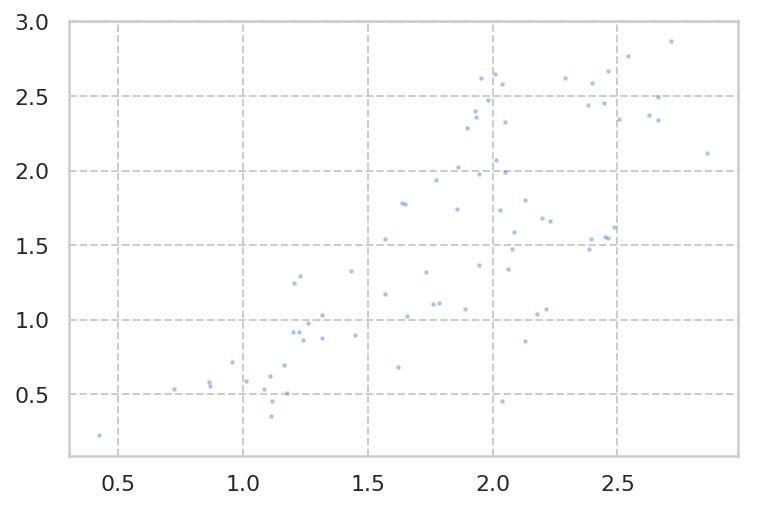

In [86]:
plt.scatter(oof_pred_lgb, oof_pred_xgb, alpha=0.3, s=2)

In [87]:
class DistAdjuster():
    def __init__(self, target):
        dist = Counter(target)
        for k in dist:
            dist[k] /= len(target)

        print("[dist]")
        print(dist)
        self.dist = dist
    
    def adjust(self, pred):
        acum = 0
        self.bound = {}
        for i in range(3):
            acum += self.dist[i]
            self.bound[i] = np.percentile(pred, acum * 100)
        print(self.bound)
        
    def classify(self, x):
        if x <= self.bound[0]:
            return 0
        elif x <= self.bound[1]:
            return 1
        elif x <= self.bound[2]:
            return 2
        else:
            return 3
        
    def fit(self, pred):
        return np.array(list(map(self.classify, pred)))

In [88]:
###################################
da = DistAdjuster(y.iloc[last_gs_idx])
p = best_thresh
pred_blending = np.sum([oof_pred_lgb*p, oof_pred_xgb*(1-p)], axis=0)
da.adjust(pred_blending)
pred_blending_mod = da.fit(pred_blending)

[dist]
Counter({3: 0.4, 0: 0.30666666666666664, 2: 0.18666666666666668, 1: 0.10666666666666667})
{0: 1.275419755915102, 1: 1.4904165507058877, 2: 1.8864160304699031}


In [89]:
###################################
score = cohen_kappa_score(pred_blending_mod, y.iloc[last_gs_idx], weights='quadratic')
print(f"seed ave: qwk score = {score}")

seed ave: qwk score = 0.5094833224329627


0    23
1     8
2    14
3    30
dtype: int64

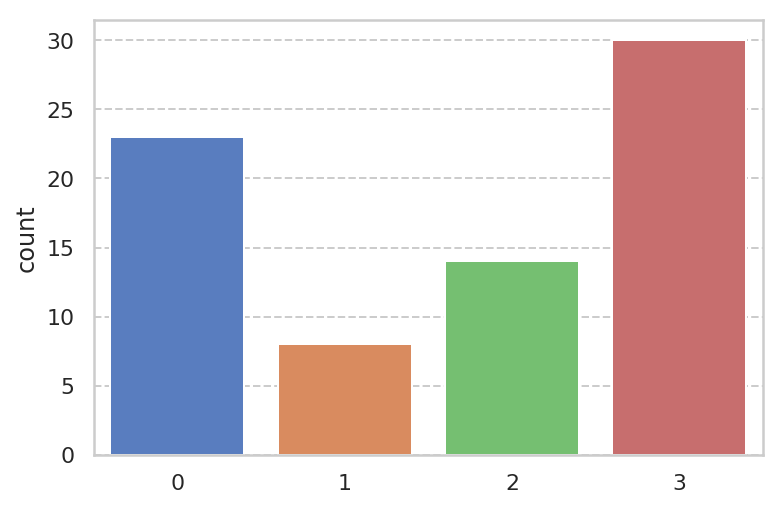

In [90]:
sns.countplot(pred_blending_mod)
pd.Series(pred_blending_mod).value_counts().sort_index()

In [91]:
###################################
da = DistAdjuster(y.iloc[last_gs_idx])
p = best_thresh
pred_blending_test = np.sum([y_pred_test_lgb*p, y_pred_test_xgb*(1-p)], axis=0)
da.adjust(pred_blending_test)
pred_blending_test_mod = da.fit(pred_blending_test)

[dist]
Counter({3: 0.4, 0: 0.30666666666666664, 2: 0.18666666666666668, 1: 0.10666666666666667})
{0: 1.5817502814346012, 1: 1.7676028115916904, 2: 2.0457251464381194}


0    52
1    18
2    31
3    67
dtype: int64

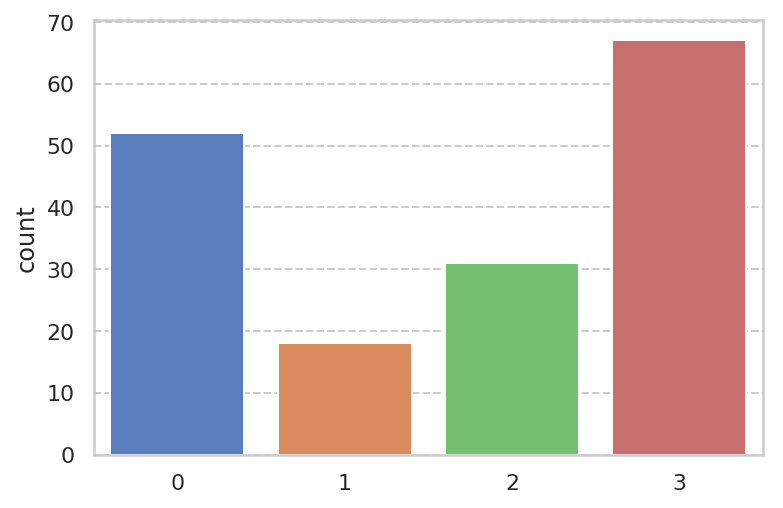

In [92]:
sns.countplot(pred_blending_test_mod)
pd.Series(pred_blending_test_mod).value_counts().sort_index()

In [93]:
submission = pd.read_csv(INPUT_PATH/'sample_submission.csv')
submission['accuracy_group'] = pred_blending_test_mod
submission.to_csv(SUBMIT_PATH/'submission.csv', index=None)
submission.head()


ValueError: Length of values does not match length of index